In [51]:
from os import rename

# 라이브러리
import numpy as np
import pandas as pd
import datetime
import fsspec
import seaborn as sns
from IPython.lib.clipboard import osx_clipboard_get
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from pandas import DataFrame
import xgboost as xgb
from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


In [52]:
# import dataset

store = pd.read_csv("C:/Users/wkdal/DREW_PY/2025/Personal_Projects/Rossmann Store Sales Prediction/store.csv")
train = pd.read_csv("C:/Users/wkdal/DREW_PY/2025/Personal_Projects/Rossmann Store Sales Prediction/train.csv")
test = pd.read_csv("C:/Users/wkdal/DREW_PY/2025/Personal_Projects/Rossmann Store Sales Prediction/train.csv")

In [53]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [54]:
store = store.rename(columns = {
    "Store" : "매장ID",
    "StoreType" : "매장유형",
    "Assortment" : "매장유형구분",
    "CompetitionDistance" : "가장가까운_경쟁매장까지거리",
    "CompetitionOpenSinceMonth" : "경쟁매장개점(월)",
    "CompetitionOpenSinceYear": "경쟁매장개점(연도)",
    "Promo2" : "상시프로모션고객참여여부",
    "Promo2SinceWeek" : "프로모션참여(주)",
    "Promo2SinceYear" : "프로모션참여(연도)",
    "PromoInterval" : "프로모션시작(월)"

})

In [55]:
store.head()

,매장ID,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [56]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [57]:
train = train.rename(columns={
    "Store" : "매장ID",
    "DayOfWeek" : "날짜(요일)",
    "Date" : "매출일",
    "Sales" : "예상매출액",
    "Customers" : "방문고객수",
    "Open" : "매장영업여부",
    "Promo" : "프로모션시행여부",
    "StateHoliday" : "공휴일정보",
    "SchoolHoliday" : "공립학교휴교여부"
})

In [58]:
train.head()

,매장ID,날짜(요일),매출일,예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [59]:
test.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [60]:
test = test.rename(columns={
    "Store" : "매장ID",
    "DayOfWeek" : "날짜(요일)",
    "Date" : "매출일",
    "Sales" : "예상매출액",
    "Customers" : "방문고객수",
    "Open" : "매장영업여부",
    "Promo" : "프로모션시행여부",
    "StateHoliday" : "공휴일정보",
    "SchoolHoliday" : "공립학교휴교여부"
})

In [61]:
test.head()

,매장ID,날짜(요일),매출일,예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


# 1. Explamatory Data Analysis(EDA)

### 1.1. 트렌드 & 계절성


#### 소주제 : 매출이 월별 1차 프로모션 시행 여부, 상시 프로모션 시행 여부, 그리고 연도에 따라 어떻게 달라지는가?

In [62]:
train.shape

(1017209, 9)

In [63]:
train.sort_values(by="매출일")

,매장ID,날짜(요일),매출일,예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부
1017208,1115,2,2013-01-01,0,0,0,0,a,1
1016473,379,2,2013-01-01,0,0,0,0,a,1
1016472,378,2,2013-01-01,0,0,0,0,a,1
1016471,377,2,2013-01-01,0,0,0,0,a,1
1016470,376,2,2013-01-01,0,0,0,0,a,1
...,...,...,...,...,...,...,...,...,...
745,746,5,2015-07-31,9082,638,1,1,0,1
746,747,5,2015-07-31,10708,826,1,1,0,1
747,748,5,2015-07-31,7481,578,1,1,0,1
741,742,5,2015-07-31,10460,1016,1,1,0,1


In [64]:
train['매출일'] = pd.to_datetime(train['매출일'])

In [65]:
train = train.set_index("매출일")

In [66]:
train.head()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부
매출일,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


- train 데이터는 100만개의 관측치(행)과 9개의 필드(열)가 있다.
- train 데이터의 매출 날짜는 2013 ~ 2015년까지 있다.
- 매출일을 문자에서 날짜로 변경하고, 인덱스로 변경

"날짜컬럼을 연도,월,일,주 컬럼으로 분리하시오."

In [67]:
train['연도'] = train.index.isocalendar().year
train['월'] = train.index.month
train['일'] = train.index.day
train['연도의N번째주'] = train.index.isocalendar().week

train['고객당평균매출'] = train['예상매출액'] / train['방문고객수']


In [68]:
train.head()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,일,연도의N번째주,고객당평균매출
매출일,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,2015,7,31,31,9.482883
2015-07-31,2,5,6064,625,1,1,0,1,2015,7,31,31,9.702400
2015-07-31,3,5,8314,821,1,1,0,1,2015,7,31,31,10.126675
2015-07-31,4,5,13995,1498,1,1,0,1,2015,7,31,31,9.342457
2015-07-31,5,5,4822,559,1,1,0,1,2015,7,31,31,8.626118


"매장이 닫혀 있는 날짜의 데이터를 확인하시오"

In [69]:
train_store_closed = train[(train.매장영업여부 == 0)]
train_store_closed

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,일,연도의N번째주,고객당평균매출
매출일,,,,,,,,,,,,,
2015-07-31,292,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-31,876,5,0,0,0,1,0,1,2015,7,31,31,NaN
2015-07-30,292,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-30,876,4,0,0,0,1,0,1,2015,7,30,31,NaN
2015-07-29,292,3,0,0,0,1,0,1,2015,7,29,31,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,1111,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,1112,2,0,0,0,0,a,1,2013,1,1,1,NaN
2013-01-01,1113,2,0,0,0,0,a,1,2013,1,1,1,NaN


array([[<Axes: title={'center': '날짜(요일)'}>]], dtype=object)

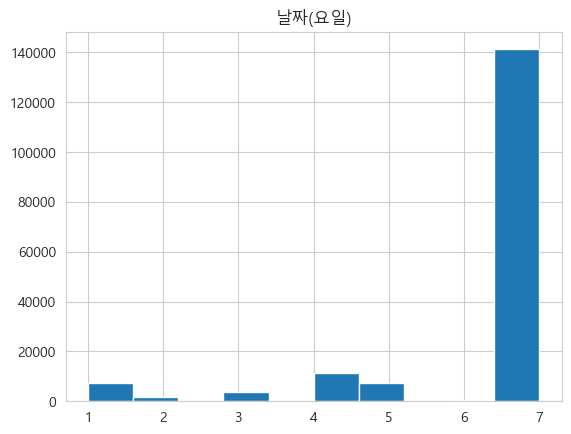

In [70]:
plt.rc('font', family='Malgun Gothic')   # ← 윈도우 한글 폰트
plt.rc('axes', unicode_minus=False)      # 음수 기호 깨짐 방지
train_store_closed.hist('날짜(요일)')

- 7번째 요일은 일요일이며, 일요일은 대부분 영업하지 않음을 알 수 있다.

<Axes: xlabel='공휴일정보'>

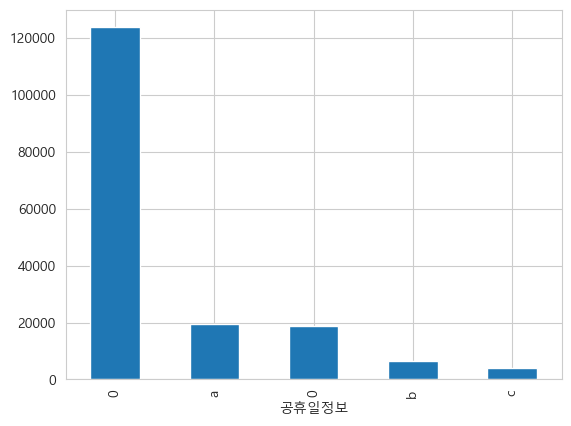

In [71]:
train_store_closed['공휴일정보'].value_counts().plot(kind='bar')

- a = 공휴일, 20000건 , b = 부활절, c = 크리스마스에 매장을 닫는다.

In [72]:
train.isnull()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,일,연도의N번째주,고객당평균매출
매출일,,,,,,,,,,,,,
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
2015-07-31,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,False,False,False,False,False,False,False,False,False,False,False,False,True
2013-01-01,False,False,False,False,False,False,False,False,False,False,False,False,True
2013-01-01,False,False,False,False,False,False,False,False,False,False,False,False,True


In [73]:
train.isnull().sum()

매장ID             0
날짜(요일)           0
예상매출액            0
방문고객수            0
매장영업여부           0
프로모션시행여부         0
공휴일정보            0
공립학교휴교여부         0
연도               0
월                0
일                0
연도의N번째주          0
고객당평균매출     172869
dtype: int64

In [74]:
train[(train.매장영업여부 == 0)].shape[0]

172817

- 매장의 휴업(0)은 172817번 이다.

In [75]:
train[(train.매장영업여부 == 1)].shape[0]

844392

- 매장 영업(1)은 844392이다.

#### "매장 관련 데이터 처리하기"

In [76]:
store.head()

,매장ID,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [77]:
store.isnull().sum()

매장ID                0
매장유형                0
매장유형구분              0
가장가까운_경쟁매장까지거리      3
경쟁매장개점(월)         354
경쟁매장개점(연도)        354
상시프로모션고객참여여부        0
프로모션참여(주)         544
프로모션참여(연도)        544
프로모션시작(월)         544
dtype: int64

#### "경쟁 매장까지의 거리가 비어있는 경우, 중앙값으로 넣어준다."

In [78]:
store['가장가까운_경쟁매장까지거리'].fillna(store['가장가까운_경쟁매장까지거리'].median(), inplace=True)

In [79]:
store.head()

,매장ID,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [80]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   매장ID            1115 non-null   int64  
 1   매장유형            1115 non-null   object 
 2   매장유형구분          1115 non-null   object 
 3   가장가까운_경쟁매장까지거리  1115 non-null   float64
 4   경쟁매장개점(월)       761 non-null    float64
 5   경쟁매장개점(연도)      761 non-null    float64
 6   상시프로모션고객참여여부    1115 non-null   int64  
 7   프로모션참여(주)       571 non-null    float64
 8   프로모션참여(연도)      571 non-null    float64
 9   프로모션시작(월)       571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [81]:
store.fillna(0,inplace=True)

In [82]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   매장ID            1115 non-null   int64  
 1   매장유형            1115 non-null   object 
 2   매장유형구분          1115 non-null   object 
 3   가장가까운_경쟁매장까지거리  1115 non-null   float64
 4   경쟁매장개점(월)       1115 non-null   float64
 5   경쟁매장개점(연도)      1115 non-null   float64
 6   상시프로모션고객참여여부    1115 non-null   int64  
 7   프로모션참여(주)       1115 non-null   float64
 8   프로모션참여(연도)      1115 non-null   float64
 9   프로모션시작(월)       1115 non-null   object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [83]:
store.isnull().sum()

매장ID              0
매장유형              0
매장유형구분            0
가장가까운_경쟁매장까지거리    0
경쟁매장개점(월)         0
경쟁매장개점(연도)        0
상시프로모션고객참여여부      0
프로모션참여(주)         0
프로모션참여(연도)        0
프로모션시작(월)         0
dtype: int64

In [84]:
store.isnull().sum().sum()

np.int64(0)

- 전체 결측치의 총 값은 0이다.

#### "테스트 데이터 처리하기"

In [85]:
test.head()

,매장ID,날짜(요일),매출일,예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [86]:
test.isnull().sum()

매장ID        0
날짜(요일)      0
매출일         0
예상매출액       0
방문고객수       0
매장영업여부      0
프로모션시행여부    0
공휴일정보       0
공립학교휴교여부    0
dtype: int64

In [87]:
test.isnull().sum().sum()

np.int64(0)

- 전체 결측치의 총 값은 0이다.

### store와 train을 병합한다.

In [88]:
train_store_joined = pd.merge(train,store, on='매장ID', how='inner')

In [89]:
train_store_joined.head()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,...,고객당평균매출,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [90]:
train_store_joined.groupby('매장유형')[['방문고객수','예상매출액','고객당평균매출']].sum().sort_values('예상매출액', ascending = True)

,방문고객수,예상매출액,고객당평균매출
매장유형,,,
b,31465621,159231395,7.987612e+04
c,92129705,783221426,9.744876e+05
d,156904995,1765392943,2.918350e+06
a,363541434,3165334859,4.043129e+06


#### 매장이 문을 닫았거나, 매출액이 없는 행

In [91]:
train_store_joined[ (train_store_joined.매장영업여부 == 0) | (train_store_joined.예상매출액 == 0)  ]

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,...,고객당평균매출,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
291,292,5,0,0,0,1,0,1,2015,7,...,NaN,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
875,876,5,0,0,0,1,0,1,2015,7,...,NaN,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"
1406,292,4,0,0,0,1,0,1,2015,7,...,NaN,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
1990,876,4,0,0,0,1,0,1,2015,7,...,NaN,a,a,21790.0,4.0,2005.0,1,18.0,2015.0,"Feb,May,Aug,Nov"
2521,292,3,0,0,0,1,0,1,2015,7,...,NaN,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,0,0,0,0,a,1,2013,1,...,NaN,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,0,0,0,0,a,1,2013,1,...,NaN,c,c,1880.0,4.0,2006.0,0,0.0,0.0,0
1017206,1113,2,0,0,0,0,a,1,2013,1,...,NaN,a,c,9260.0,0.0,0.0,0,0.0,0.0,0
1017207,1114,2,0,0,0,0,a,1,2013,1,...,NaN,a,c,870.0,0.0,0.0,0,0.0,0.0,0


172,871개의 매장이 문을 닫았으며, 예상매출액이 0이다.

In [92]:
# ~(조건) : 매장이 닫힌 것이 아닌 행, 매장이 열린 행

train_store_joined_open = train_store_joined[~((train_store_joined.매장영업여부 ==0) | (train_store_joined.예상매출액==0))]
train_store_joined_open

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,...,고객당평균매출,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,3375,566,1,0,a,1,2013,1,...,5.962898,b,a,150.0,9.0,2006.0,0,0.0,0.0,0
1016827,733,2,10765,2377,1,0,a,1,2013,1,...,4.528818,b,b,860.0,10.0,1999.0,0,0.0,0.0,0
1016863,769,2,5035,1248,1,0,a,1,2013,1,...,4.034455,b,b,840.0,0.0,0.0,1,48.0,2012.0,"Jan,Apr,Jul,Oct"
1017042,948,2,4491,1039,1,0,a,1,2013,1,...,4.322425,b,b,1430.0,0.0,0.0,0,0.0,0.0,0


### Correlation Analysis

두 변수간의 선형 관계가 얼마나 강한지 측정 (상관 계수)

(a가 증가하면 b도 증가하는가? 함께 움직이는 정도를 보임)

In [93]:
train_store_joined.head()

,매장ID,날짜(요일),예상매출액,방문고객수,매장영업여부,프로모션시행여부,공휴일정보,공립학교휴교여부,연도,월,...,고객당평균매출,매장유형,매장유형구분,가장가까운_경쟁매장까지거리,경쟁매장개점(월),경쟁매장개점(연도),상시프로모션고객참여여부,프로모션참여(주),프로모션참여(연도),프로모션시작(월)
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,625,1,1,0,1,2015,7,...,9.702400,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,8314,821,1,1,0,1,2015,7,...,10.126675,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,13995,1498,1,1,0,1,2015,7,...,9.342457,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,5,4822,559,1,1,0,1,2015,7,...,8.626118,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


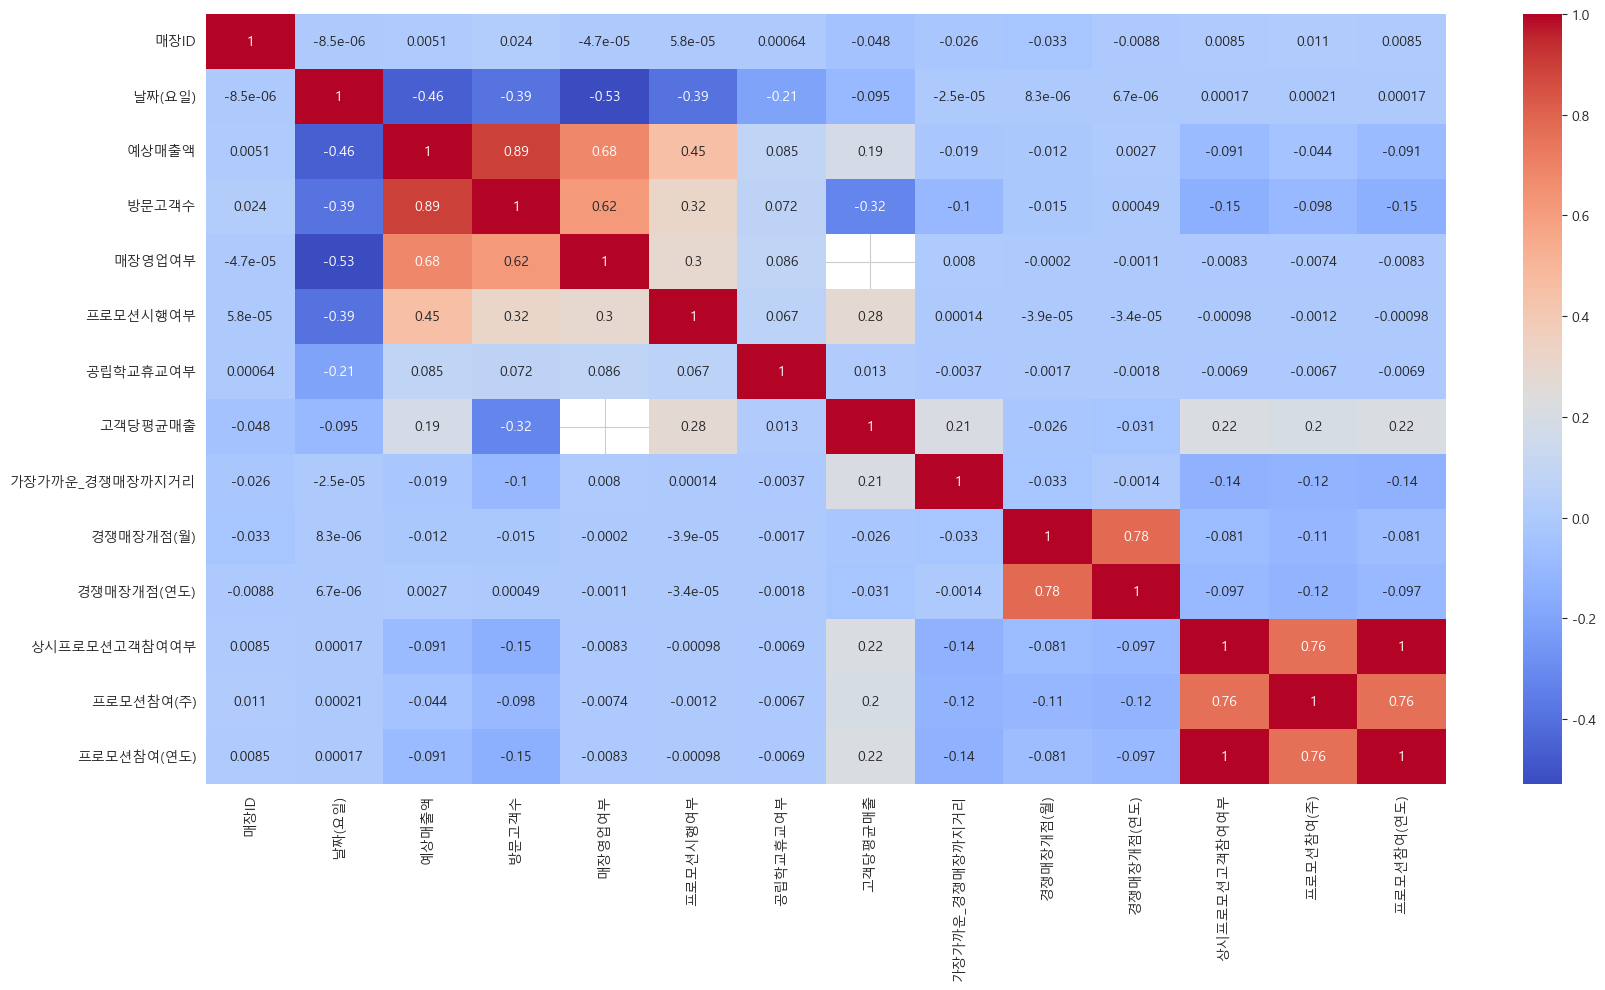

In [94]:
# 숫자형 컬럼만 사용하여 상관관계 분석(공휴일정보,매장유형,매장유형구분 제외)
numeric_df = train_store_joined.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(20, 10))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

(1)차 프로모션 시행여부 & 예상매출액의 ▲상관계수 0.45입니다. 프로모션을 하면 매출액이 증가하는 경향이 뚜렷합니다.


(1)차 프로모션 시행여부 & 방문고객수의 ▲상관계수 0.32입니다. 프로모션을 하면 방문 고객수가 증가합니다.


상시프로모션참여여부 & 고객당평균매출의 ▲상관계수 0.22입니다. 상시프로모션은 고객수를 늘리기보다 고객 1명당 구매액을 증가시키는 효과가 있을 가능성이 있습니다.
장기 구독형 할인이나 시즌 반복 할인 고려 가능합니다.


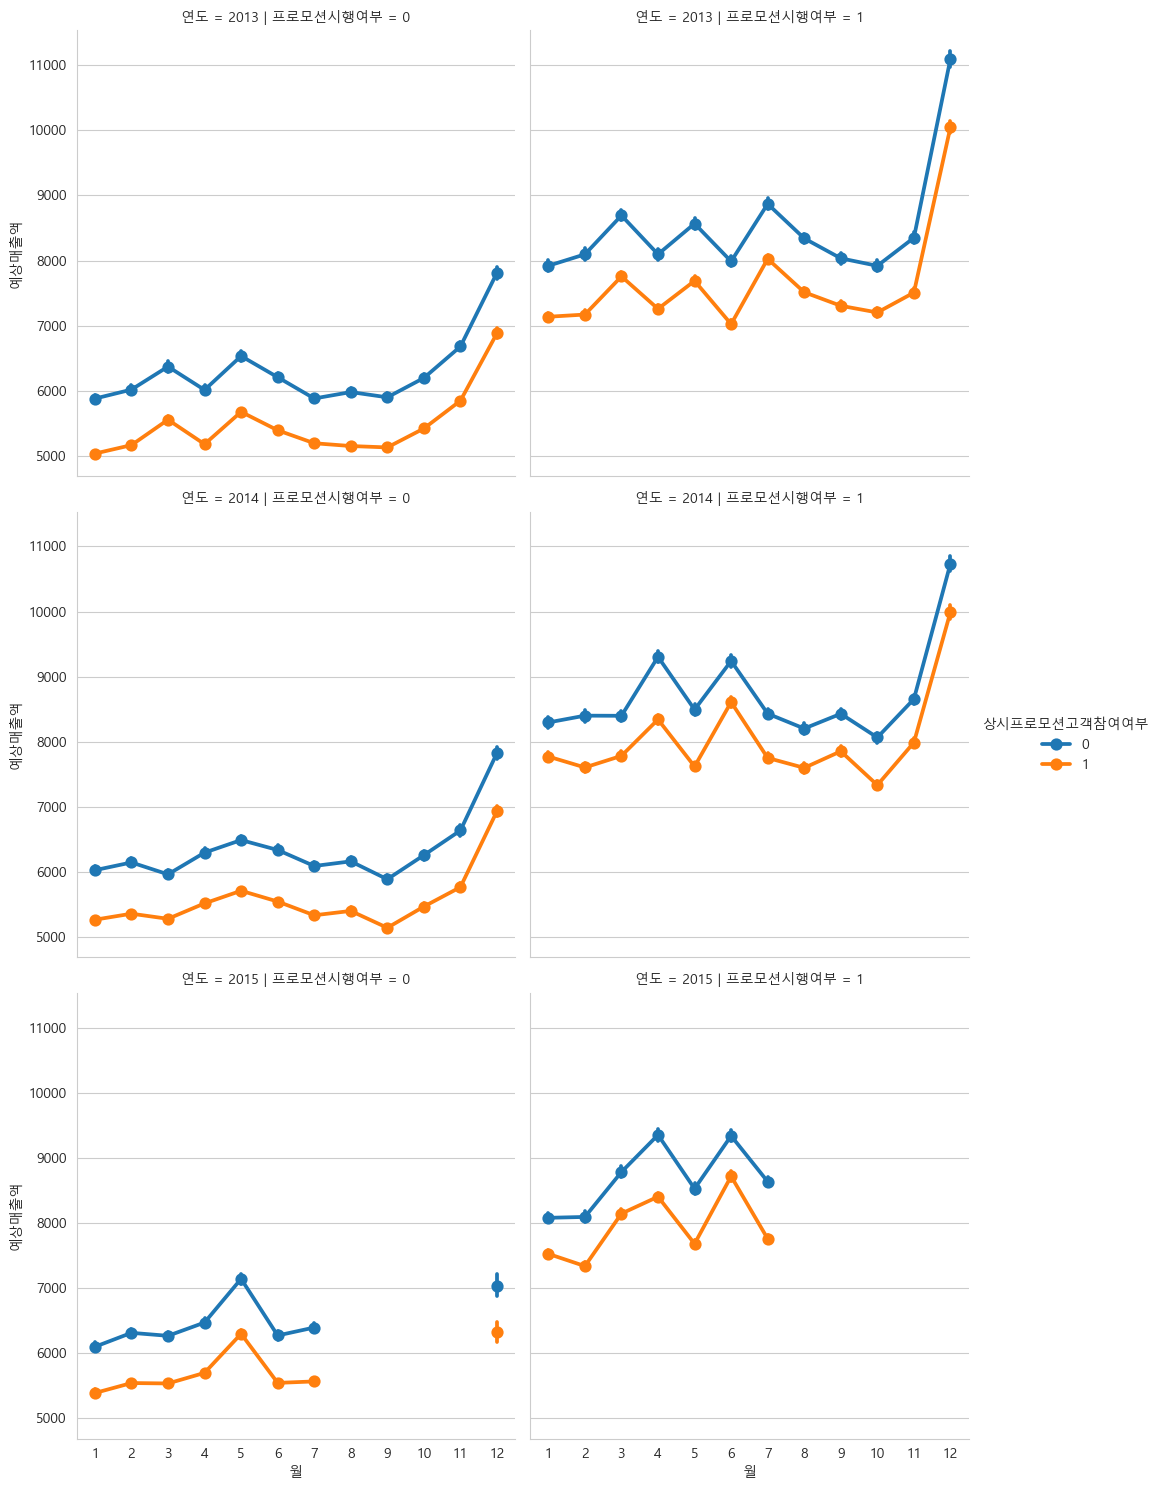

In [95]:
sns.catplot(data = train_store_joined_open, x='월', y='예상매출액',
              col ='프로모션시행여부', hue='상시프로모션고객참여여부', row='연도',kind='point')

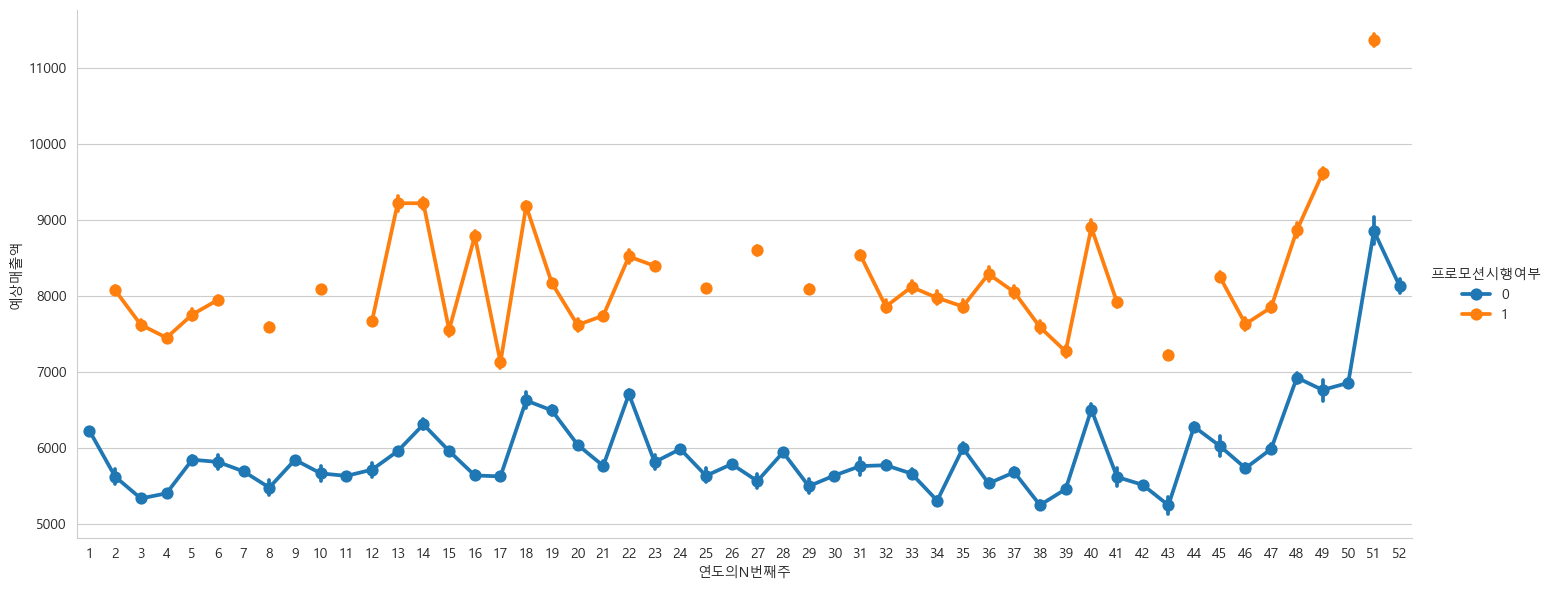

In [96]:
# 요일별 매출과 추세 분석

sns.catplot(data= train_store_joined_open, x='연도의N번째주', y="예상매출액",
              hue='프로모션시행여부', kind = 'point', height=6, aspect=2.4)

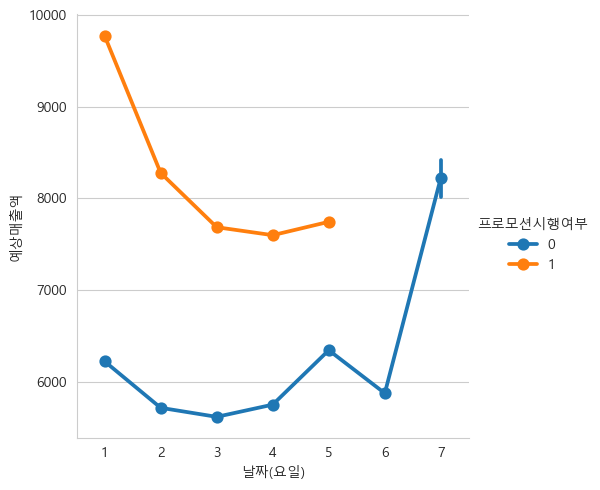

In [97]:
# Sales and trend over days
sns.catplot(data= train_store_joined_open, x='날짜(요일)', y="예상매출액",
              hue='프로모션시행여부',kind = 'point')

위 차트에서 0은 프로모션 없음 1은 프로모션이 시행됨을 의미합니다.
주말(토요일, 일요일)에는 프로모션이 제공되지 않습니다.

사람들은 주말에 생필품을 구매하러 많이 가기 때문에, 프로모션이 없어도 매출이 크게 증가하는 경향이 있습니다.

프로모션은 월요일에 가장 많이 진행되며, 그날 매출 역시 높게 나타납니다.

프로모션은 화요일에 진행한 경우 많이 구매하는 경향이 있습니다.


# 2. Time Series Analysis (시계열 분석)

이 섹션에서는 매장 유형별로 각각 하나의 매장(타입 a, b, c, d)을 선택하여 분석합니다.

### 시계열 데이터를 주 단위로 묶어서 추세를 시각화

In [98]:
pd.plotting.register_matplotlib_converters()

pandas의 날짜 데이터를 matplotlib 그래프에서 문제 없이 쓰도록 "등록"하는 기능이다.

pandas는 Timestamp, Period와 같은 특수한 날짜/시간 타입이 있다.
그런데 matplotlib은 원래 이 타입들을 그대로 이해하지 못하기에, pandas를 읽을 수 있도록 도와준다.

- pd.Timestamp (판다스 날짜)
- pd.Period (기간)
- np.datetime64 (넘파이 날짜)
- datetime.datetime (파이썬 기본 날짜)
- datetime.date
- datetime.time

In [108]:
train['예상매출액'] = train['예상매출액'] * 1.00

train['예상매출액'].head()

매출일
2015-07-31     5263.0
2015-07-31     6064.0
2015-07-31     8314.0
2015-07-31    13995.0
2015-07-31     4822.0
Name: 예상매출액, dtype: float64

In [109]:
train.매장ID.unique()

array([   1,    2,    3, ..., 1113, 1114, 1115], shape=(1115,))

In [110]:
sales_a = train[train.매장ID == 2 ]['예상매출액']
sales_b = train[train.매장ID == 85]['예상매출액'].sort_index(ascending = True)
sales_c = train[train.매장ID == 1]['예상매출액']
sales_d = train[train.매장ID == 13]['예상매출액']

<Axes: xlabel='매출일'>

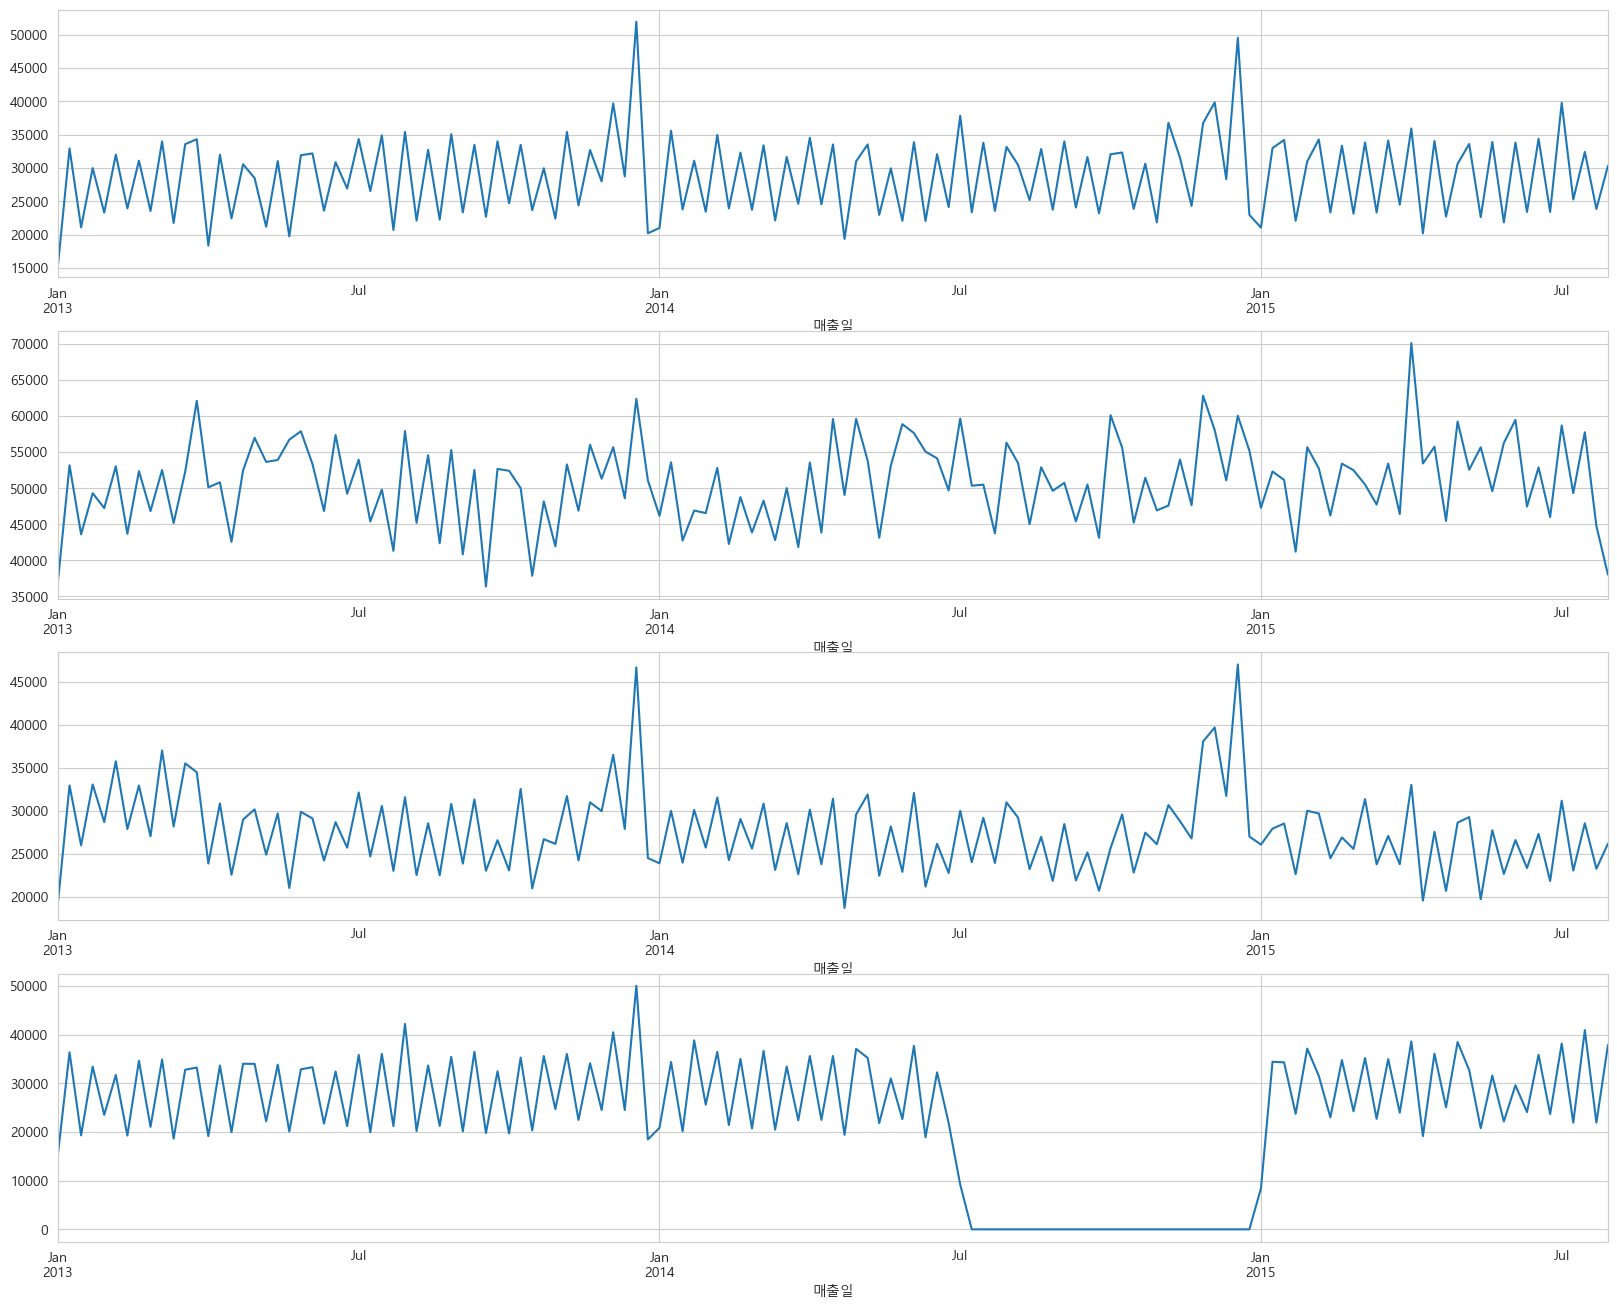

In [115]:
# Assigning one store from each category
frame, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (20,16) )

# Visualize Trend
sales_a.resample('w').sum().plot(ax = ax1) # 데이터를 주 단위로 묶어서 resample한다.
sales_b.resample('w').sum().plot(ax = ax2)
sales_c.resample('w').sum().plot(ax = ax3)
sales_d.resample('w').sum().plot(ax = ax4)


위 차트를 보면 연말에 매출이 가장 높게 나타나는 경향을 확인할 수 있습니다.
12월은 크리스마스 시즌이기 때문에, 이 시기에 고객 지출이 증가하면서 매출이 크게 상승한 것으로 보입니다.

하지만 월말에는 매출이 다시 감소하는 흐름을 보입니다.

반면, 매장 a와 b는 흐름이 비슷한데, 이는 해당 기간의 데이터가 부족하거나, 해당 시기에 매장이 운영되지 않았기(휴점) 때문일 가능성이 있습니다.

### 시계열 정상성 알아보기

#### 정의
시계열(Time Series)의 정상성(Stationarity)란, 시간이 지나도 시계열의 통계적 성질이 변하지 않는 것을 의미한다.

정상성을 가진 데이터는 다음 특징을 가진다.
- 평균이 일정함 (Constant mean)
- 분산이 일정함 (Constant variance)
- 시간에 따라 공분산이 일정함 (Constant Covariance)
즉, 시간이 지나도 데이터의 분포 형태가 변하지 않는 시계열을 말합니다.

시계열 모델들은 왜 정상성(Stationarity)를 봐야하나?
- 평균이 계속 변함
- 분산이 계속 변함
- 계절성이 너무 강함
이런 데이터는 그 상태로는 예측 모델이 학습할 수 없음(과거 패턴이 미래에도 유지된다는 가정)

#### 시계열 정상성 검정 방법(두 가지)
시계열이 정상성인지 확인하는 방법은 크게 두 가지입니다.

A) Rolling Mean(이동 평균) - 시각적 검사

B) Dickey-Fuller Test - 통계적 검정

#### A) Rolling Mean(이동 평균) - 시각적 검사

Rolling Mean(이동 평균 분석)은 모델의 안전성을 확인하기 위해 창(Window)을 일정 단위로 옮기면서 평균(또는 분산)을 계산하는 방법입니다.

여기서는 주 단위(weekly)로 창을 이동시키면서 평균을 계산합니다.

- 원본 데이터와 이동 평균을 함께 그려 비교함
- 이동 평균선이 크게 흔들리지 않고 일정하다면 ? 데이터가 정상적(Stationary)일 가능성이 큼


#### B) Dickey-Fuller Test - 통계적 정상성 검정
Dickey-Fuller 검정은 p-value 등의 통계값을 제공하며, 이를 통해 시계열이 정상성인지 판단합니다.

기준 :

- p-value < 임계값(일반적으로 0.05기준)
    - 귀무가설을 기각하며,
        - 데이터는 정상성(Stationary)입니다.


In [124]:
## (아래) 시각적인 정상성 체크
def test_stationarity(timeseries):
    roll_mean = timeseries.rolling(window=7).mean() # 7개 관측치를 하나의 묶음으로 잡고 평균을 구합니다.
    roll_std = timeseries.rolling(window=7).std()  # 7개 관측치를 하나의 묶음으로 잡고 평균을 구합니다.
    # 1일차 값(앞에 데이터가 부족해서 NaN) > 7일차 값(1-7일 평균) > 8일차 값 (2-8일차 평균) 이런식으로 창(window)가 한 칸씩 앞으로 슬라이딩 합니다.
    # 이유 ? 시계열 정상성이면, 평균, 분산이 시간에 따라 크게 안 바뀝니다.

    plt.subplots(figsize = (16,6))  # 주(week) 단위로 다시 묶고, 원본 + 이동평균 + 이동 표준편차를 주 단위로 그립니다.
    original = plt.plot(timeseries.resample('w').mean(), color = 'blue', linewidth = 3, label = 'Orginal')
    roll_mean = plt.plot(roll_mean.resample('w').mean(), color = 'red', linewidth = 3, label = 'RollingMean')
    roll_mean = plt.plot(roll_std.resample('w').mean(), color = 'green', linewidth = 3, label = 'RollingStd')

    plt.legend(loc='best')  #legend : 파랑/빨강/초록색이 어떤 라인인지 표시
    plt.show()  # 그림 화면에 띄우기


## (아래) dickey - fuller 테스트 실행
    print('Result of Dickey-Fuller test: ')
    result = adfuller(timeseries, autolag='AIC')  #adfuller()함수는 이 시계열이 정상적인지 아닌지를 통계적으로 검정하는 함수, #aic를 기준으로 최적 lag(시차)를 선택함.

    print('ADF Statestics : %f' %result[0])
    print('P-value: %f' %result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(key, value)

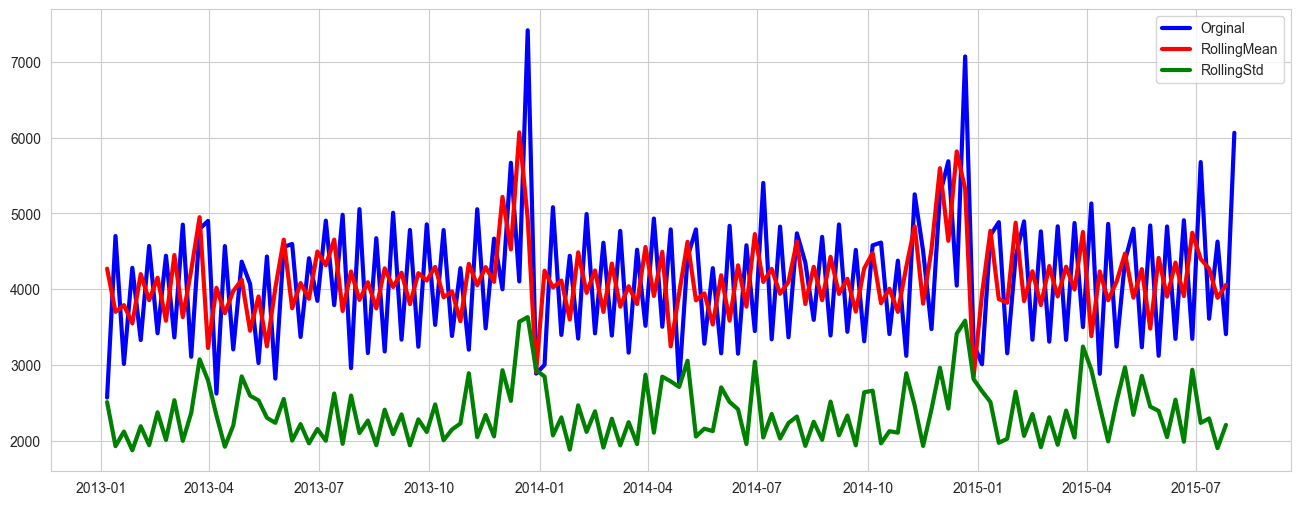

Result of Dickey-Fuller test: 
ADF Statestics : -6.218237
P-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [126]:
test_stationarity(sales_a)

#### 해석
귀무가설(비정상)을 기각하고, 대립가설(정상)이다라는 개념을 넣으면, P-value가 0.05(5% 유의수준)보다 훨씬 작습니다.

결국 0.00000이라서, 귀무가설이 기각되고 정상성(stastionary)라고 결론을 냈습니다.

따라서 추가적인 변환(트랜스포메이션)을 적용할 필요가 없습니다.

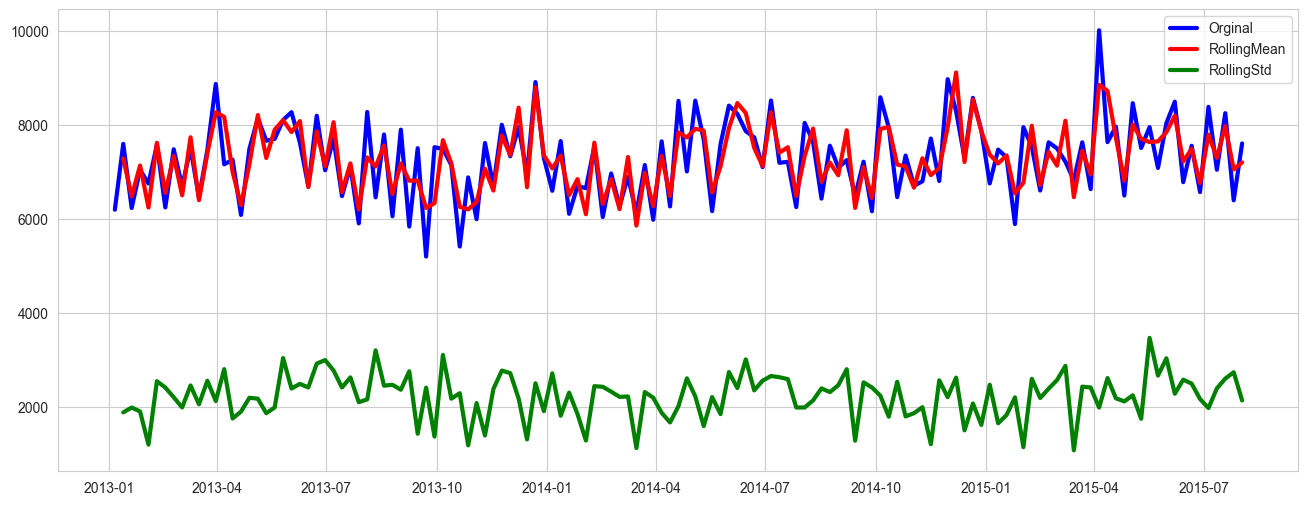

Result of Dickey-Fuller test: 
ADF Statestics : -5.660918
P-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459


In [127]:
test_stationarity(sales_b)

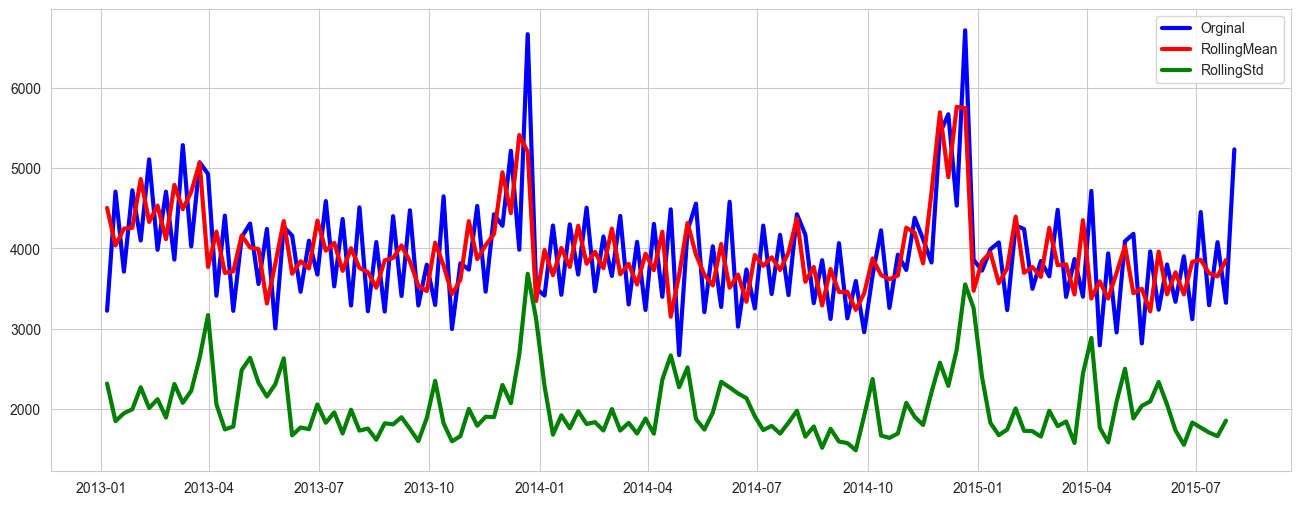

Result of Dickey-Fuller test: 
ADF Statestics : -4.374784
P-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583


In [128]:
test_stationarity(sales_c)

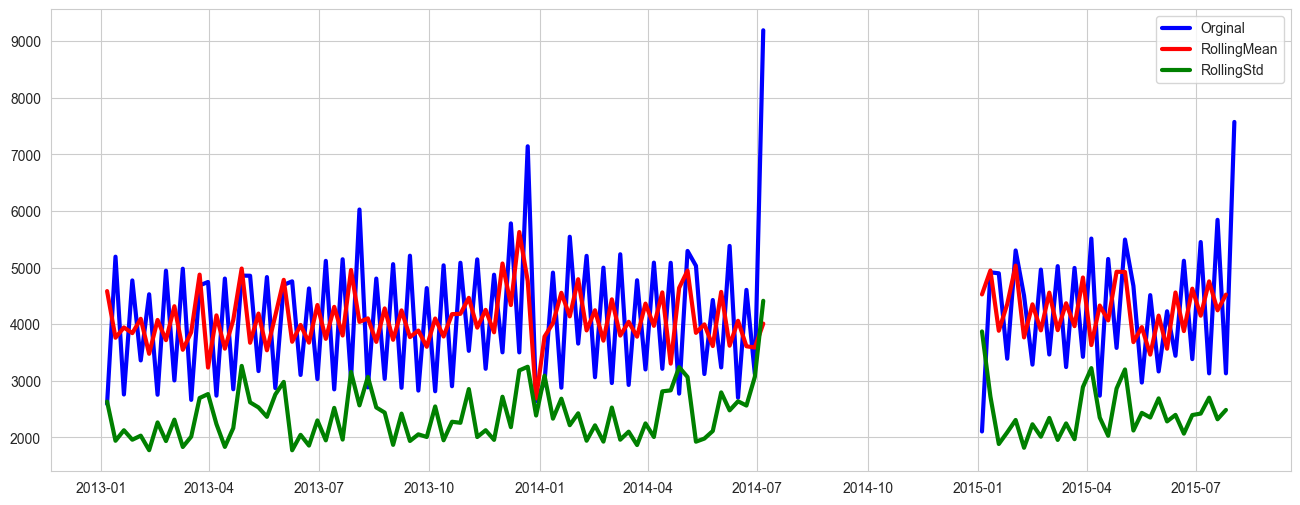

Result of Dickey-Fuller test: 
ADF Statestics : -6.237461
P-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


In [129]:
test_stationarity(sales_d)

위의 차트들을 보면, 데이터의 평균과 분산이 시간에 따라 거의 변화하지 않는 것을 확인할 수 있습니다.
따라서 추가적인 변환(트랜스포메이션)을 적용할 필요가 없습니다.

### 트렌드(추세)와 계절성을 생성

### 추세와 계절성

추세 : 시간이 흐르면서 평균이 움직이는 것으로 그래프를 그렸을 때 올라가거나, 내려가거나 , 형태가 변합니다.

계절성 : 반복되는 규칙적인 패턴이 존재하는 것입니다. 7일 30일 1년 등 일정 주기로 반복합니다.

In [141]:
def plot_timeseries(예상매출액,매장유형) :

    fig, axes = plt.subplots(2, 1, sharex=True, sharey = False)
    fig.set_figheight(6)
    fig.set_figwidth(20)

    decomposition = seasonal_decompose(예상매출액, model = 'additive', period= 365)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid

    axes[1].plot(estimated_seasonal, 'g', label = 'Seasonality')
    axes[1].legend(loc = 'upper left');

    axes[0].plot(estimated_trend, label = 'Trend')
    axes[0].legend(loc = 'upper left');

    plt.title('Decomposition Plots')

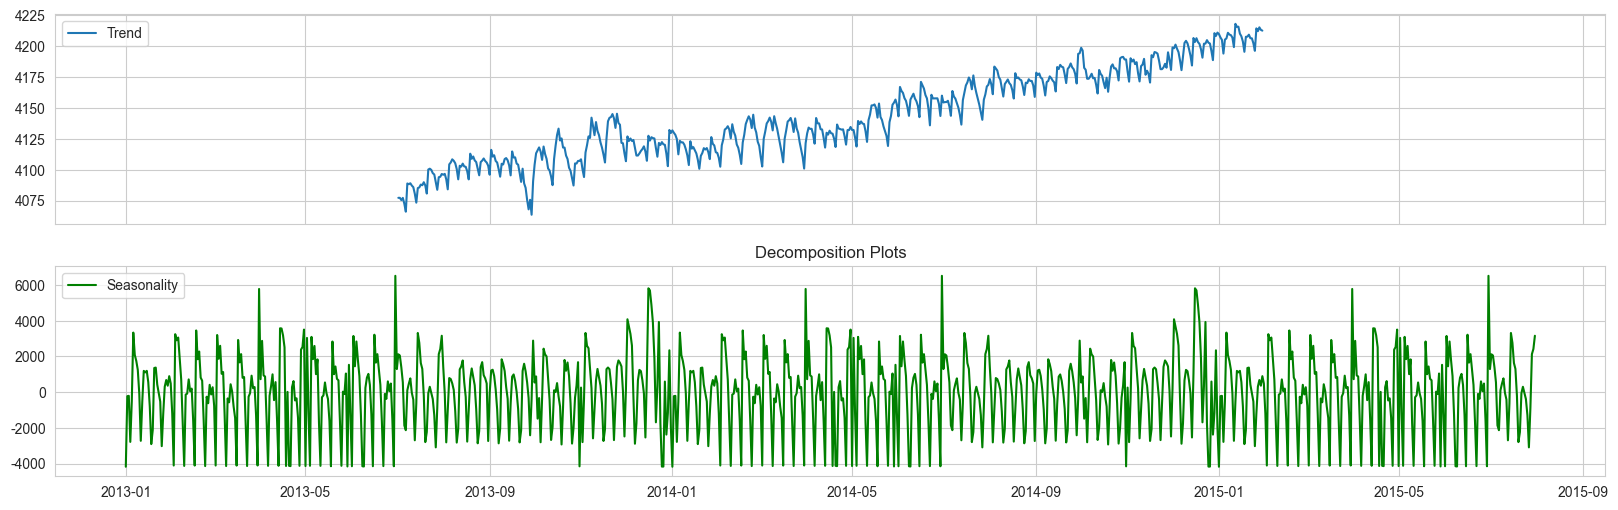

In [142]:
plot_timeseries(sales_a, 'a')

추세 그래프(파랑)

- 데이터 시작부터 끝까지 매출이 꾸준히 상승하는 패턴입니다.

- 중간에 약간의 흔들림이 있지만 전체적으로는 선명한 상승 그래프입니다.

왜 이런 추세가 생길까?

- 매장 리뉴얼(확장, 인테리어 개선)

- 주변 인구 증가

- 브랜드 충성 고객 증가

- 장기적인 마케팅 효과

예상

계절성 (초록)

- 계절성 그래프가 규칙적인 톱니 모양입니다.

- 아주 강한 반복 패턴이 존재합니다. 이는 요일 효과 때문입니다.

왜 이렇게 반복될까요?

- 토요일 매출이 높습니다.

- 일요일(closed) 매출 0의 영향을 받습니다.

- 주중 패턴이 일정하게 반복합니다.

    - 이유) Rossmann 데이터는 365일(연간 주기) 보다 7일(주간 주기) 패턴이 훨씬 강합니다.
        - 현실적인 계절성 주기가 1년 주기가 아니라 1주일 주기이기에
        - '월요일 매출 패턴', '금요일 매출 패턴', '토요일 매출 급증', '일요일(Closed) 매출 0' 입니다.
        - 이런 요일별 행동 패턴이 훨씬 강해서 모든 매장이 톱니 패턴으로 보입니다.

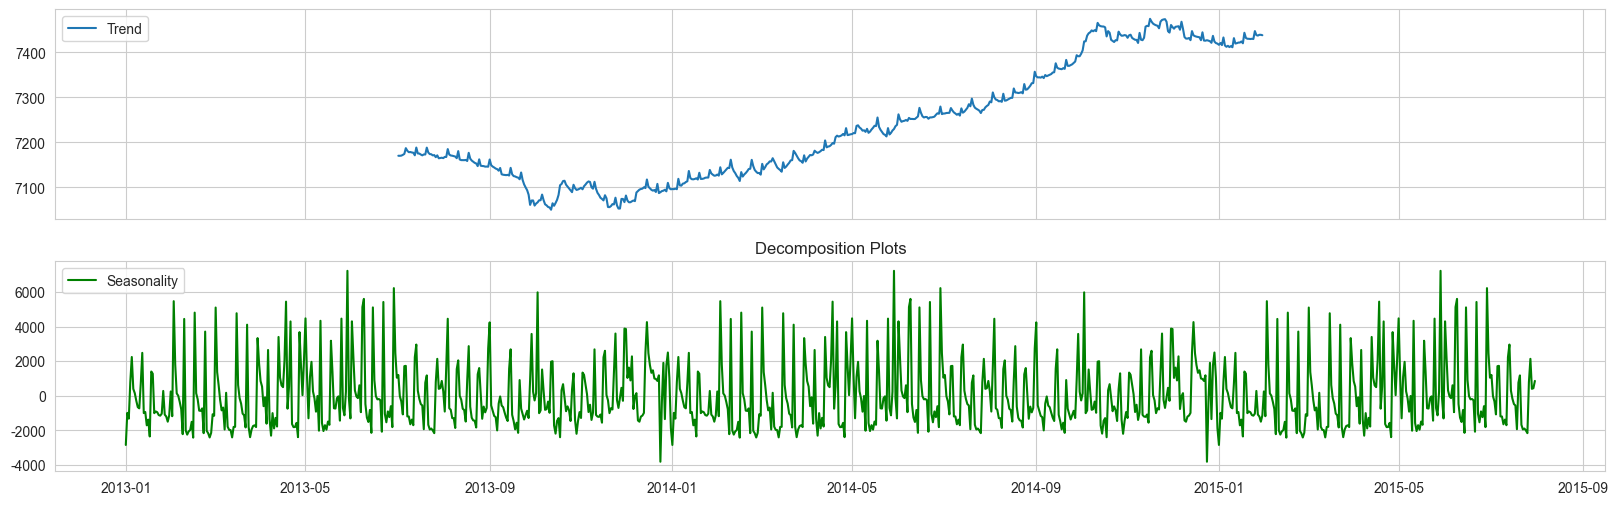

In [143]:
plot_timeseries(sales_b, 'b')

트렌드(파랑) 해석
- 초반에 매출이 내려갑니다. 이는 경쟁 매장이 등장했거나 이슈의 영향이 있을 수 있습니다.
- 중간(2014년 이후)부터 강하게 상승합니다.
- 후반에 다시 살짝 안정화가 됩니다.

원인은 무엇일까요?
- B 매장 타입은 할인 매장이거나 지역의 영향을 받을 수 있습니다.
- 가격 정책 변화
- 프로모션 강화
- 매장 운영 시간 변경
- 시즌 이벤트(부활절, 크리스마스  연계 등)이 영향이 있을 수 있습니다.

계절성 (초록) 해석

위의 A타입 매장과 같은 톱니바퀴 유형을 보입니다.

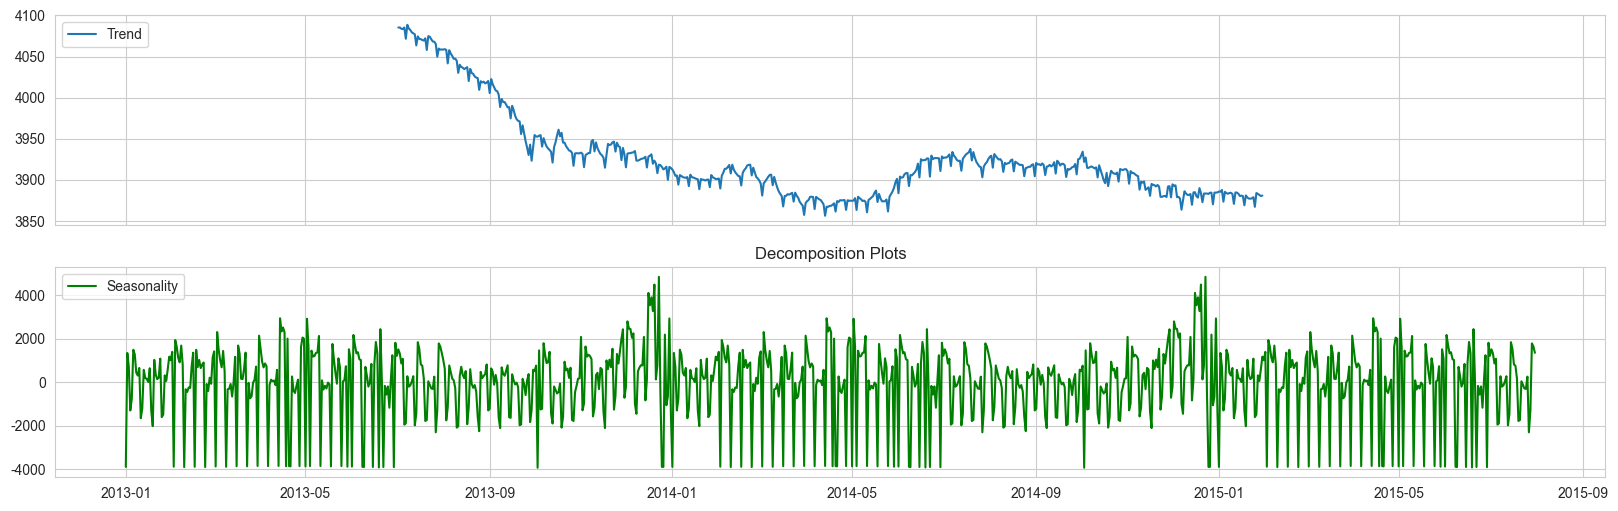

In [146]:
plot_timeseries(sales_c, 'c')

트렌드 (파랑색) 해석

- 시작부터 끝까지 계속적인 하락을 보입니다.

- 후반부에 약간 반등이 있지만 전체적으로는 내려가는 방향입니다.

왜 하락을 보일까요?

- C 타입 매장은 종종 편증된 고객층을 가진 경우가 많을 수 있습니다. (산업단지 인근, 시골 등)

- 인구 감소 지역

- 프로모션 효과 부족

- 매장 규모가 작음으로 인해 시장 환경이 좋지 않을 수도 있습니다.


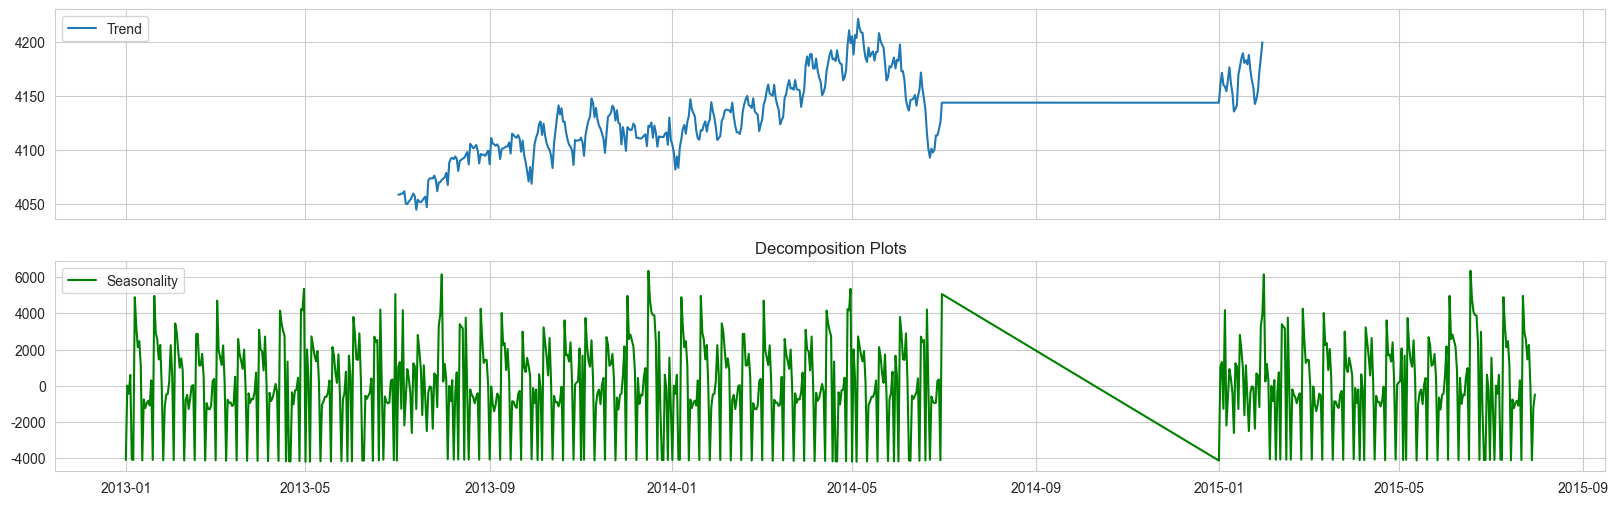

In [145]:
plot_timeseries(sales_d, 'd')

트렌드(추세) 해석

- 초반(2013년 초  ~ 2014년 초)
매출이 꾸준히 상승하는 모습을 보입니다.

- a 타입과 비슷하게 성장중인 매장입니다.

- 중간(2014년 중반)
갑작스런 매출이 급락하며, 데이터 누락 또는 결측값이 있을 수 있습니다. 혹은 해당 기간 동안 매장이 휴업/공사 일 수 있습니다.


계절성 해석

정상 구간에서는 주간 패턴(톱니)가 잘 보입니다.
그러나 데이터 누락으로 인해 특정 기간 추정할 근거가 없습니다.

계절성과 추세가 있는 것을 확인할 수 있습니다.

따라서 우리는 이 두 요소를 모두 반영할 수 있는 예측 모델을 사용해야 합니다.

예를들어 sarimax 나 Prophet같은 모델이 이에 적합합니다.

이 모델들은 추세를 다루고, 계절성을 자동으로 분리하고, 잔차만 예측하는 방식으로 설계되었습니다.

(센서 데이터, 온도 보정 값, 통신 트래픽 등에도 사용 가능)


# 시계열 예측（Time Series Forecasting)

### 평가 지표 (Evaluation Metrics)

1. MAE - 평균 절대 오차(Mean Absolute Error)

: 예측값과 실제값의 절대적 차이 (예측 - 실체)의 평균을 의미합니다.

: 값이 작을수록 모델이 실제값과 가깝게 예측했다는 의미입니다.

2. RMSE - 평균 제곱근 오차(Root Mean Sqaure Error)

: 예측값과 실제값의 제곱 오차를 평균낸 뒤 제곱근을 취한 값입니다.

: 큰 오차에 더 큰 패널티를 줍니다.

: 시계열 모델을 비교할 때 가장 널리 사용되는 지표 중 하나입니다.


### 모델 01 : 계절형 ARIMA(SARIMA)
Seasonal Autoregressive Integrated Moving Average

SARIMA를 사용하려면 먼저 p, d, q 값을 찾아야 합니다.

(1) p(AR : Autogressive) - 자기 회귀 차수

- 과거 시점의 종속변수를 몇 개 사용할지 결정합니다.(과거 값(시점)을 몇 개 참고해서 현재 값을 예측할지)

    - p = 1 → 바로 전날만 참고

    - p = 2 → 전날 + 전전날을 참고

    - p = 7 → 7일 전까지 참고 (요일 패턴을 반영)

- PACF(부분자기상관함수)에서 결정합니다.

(2) q(MA : Moving Average) - 이동평균 차수

- 과거 예측 오차를 몇 개 사용할지 결정합니다.

- ACF(자기상관함수)에서 결정합니다.

    - q = 1 → 바로 전 오차를 참고

    - q = 2 → 2단계 전 오차까지 반영

(3) d - 비계절 차분 횟수
- 추세(Trend)를 제거해서 시계열을 안정적(stationary)으로 만들기 위한 단계 , 시계열을 정상성 상태로 만들기 위해 몇 번 차분하는지 의미합니다.

  - 추세를 제거하기 위해 사용합니다. ex. 계속 증가하는 매출 그래프는 추세가 존재합니다. 해마다 반복되는 계절 패턴이면 시간이 흐를수록 분산이 커집니다.)

  - 차분은 현재값 - 이전값이며, 계산해서 추세를 제거합니다.

    (언제 사용? 차분 = 오늘 몸무게 - 어제 몸무게 일 때, 체중 자체는 계속 늘어나지만 하루 증가량은 거의 일정하기에 차분 데이터가 예측이 쉽습니다.)

  - d = 너무 작으면 → 데이터가 아직 추세가 남아 있음

  - d = 너무 크면 → 데이터가 과하게 변화되어 의미가 사라짐

  - 즉, d는 “시계열을 ARIMA가 읽을 수 있는 상태(정상성)로 만드는 과정"


### p,d,q 값을 찾는 방법 - ACF / PACF 사용

(1) ACF (Autocorrelation Function, 자기상관함수)

    - 현재 시점과 여러 시점 과거 값들간의 상관관계를 측정합니다.

(2) PACF (Partial Autocorrelation Function, 부분자기상관함수)

    - 중간에 끼어 있는 값들의 영향을 제거한 후, 현재와 특정 값 간의 순수한 상관관계를 측정하는 함수입니다.


ACF와 PACF는 바로 이 하이퍼파라미터를 결정


### p와 q를 고르는 규칙

(1) p (AR 차수)

    - PACF 그래프에서 처음으로 상한선을 넘어서는 값입니다.


(2) q (MA 차수)

    - ACF 그래프에서 처음으로 상한선을 넘어서는 값입니다.

### Autocorrelation Function(자동상관 함수)란?

시계열 데이터가 자기 자신과 과거 값 사이에 얼마나 관련(상관 관계)이 있는지 측정하는 함수입니다.

예를 들면 :

    - 오늘 매출이 어제 매출가 얼마나 비슷한지?

    - 오늘 온도가 3일 전 온도와 얼마나 비슷한지?

    - 오늘 방문자 수가 일주일 전과 얼마나 연관이 있는지?



# Autocorrelation Function to make ACF and PACF
### ACF와 PACF 그래프를 만들기 위해, Aoutocorrelation Function을 계산합니다.

In [151]:
# Autocorrelation Function to make ACF and PACF   # ACF/PACF 그래프를 생성하기 위한 자동상관 함수
def auto_corr(예상매출액):  # 예상매출액(시계열 데이터)을 입력받아 ACF/PACF를 계산하는 함수
    lag_acf = acf(예상매출액, nlags=30)  # ACF 계산: 30개의 lag에 대해 자기상관계수 계산
    lag_pacf = pacf(예상매출액, nlags=20, method='ols')  # PACF 계산: 20개의 lag에 대해 부분자기상관계수 계산

    plt.subplot(121)  # 첫 번째 그래프(좌측)에 ACF 플롯 생성
    plt.plot(lag_acf)  # ACF 값 시각화
    plt.axhline(y=0, linestyle='--', color='red')  # 기준선 y=0 표시
    plt.axhline(y=1.96 / np.sqrt(len(sales_a)), linestyle='--', color='red')  # +95% 신뢰구간
    plt.axhline(y=-1.96 / np.sqrt(len(sales_a)), linestyle='--', color='red')  # -95% 신뢰구간
    plt.title('ACF')  # 그래프 제목: ACF

    plt.subplot(122)  # 두 번째 그래프(우측)에 PACF 플롯 생성
    plt.plot(lag_pacf)  # PACF 값 시각화
    plt.axhline(y=0, linestyle='--', color='red')  # 기준선 y=0 표시
    plt.axhline(y=1.96 / np.sqrt(len(sales_a)), linestyle='--', color='red')  # +95% 신뢰구간
    plt.axhline(y=-1.96 / np.sqrt(len(sales_a)), linestyle='--', color='red')  # -95% 신뢰구간
    plt.title('PACF')  # 그래프 제목: PACF


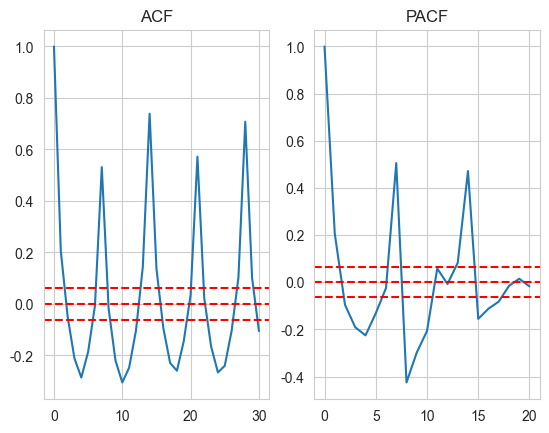

In [152]:
auto_corr(sales_a)

#### ACF 해석

- lag 1에서 큰 양수(+) 상관이 나타납니다.

- lag 7, 14, 21, 28 부근에서 규칙적인 큰 피크가 반복됩니다.

(1) 데이터에 강한 주기성(seasonality)가 있습니다.

- 7일(일주일) 단위로 매출이 반복되는 Rossmann 판매 데이터에서 자주 나오는 패턴으로 주기적으로 패턴이 강합니다.

(2) q값을 결정하는 부분

- acf에서 lag 1이 신뢰구간을 처음으로 크게 넘었습니다 q=1



#### PACF 해석

lag 1에서 강한 피크(신뢰구간을 초과)를 보입니다.
다른 값들은 신뢰구간을 넘지 않습니다.

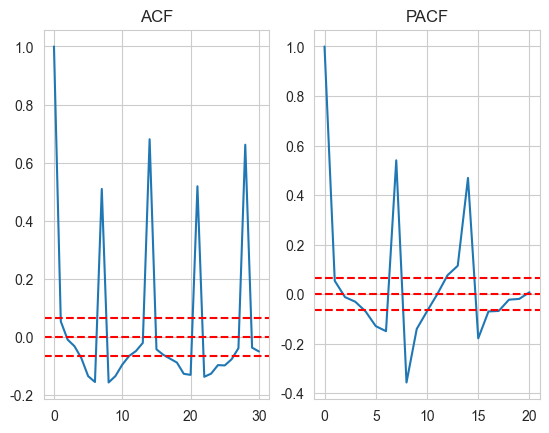

In [153]:
auto_corr(sales_b)

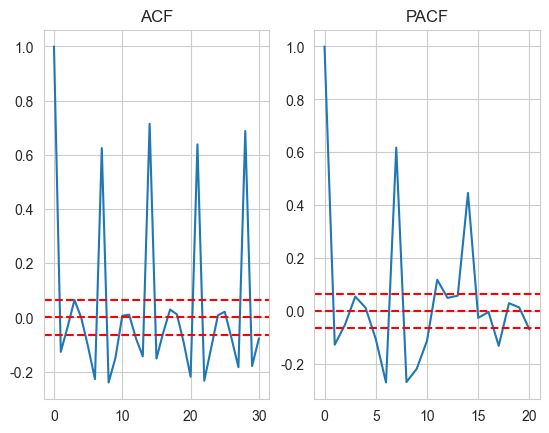

In [154]:
auto_corr(sales_c)

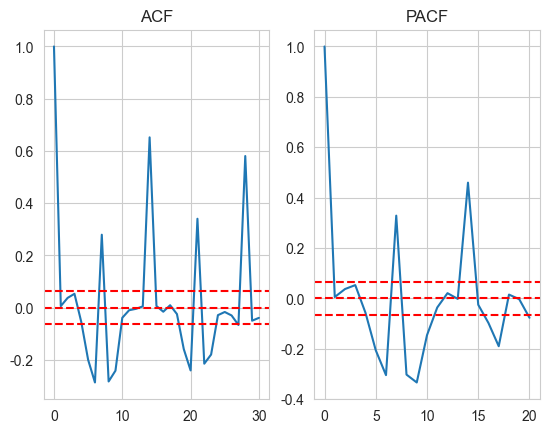

In [155]:
auto_corr(sales_d)

### 해석
p = 2, q = 2는 신뢰구간을 넘습니다

어떤 조합의 p, q, d가 가장 낮은 AIC(Akaike Information Criterion, 아-카이-키 인-퍼-메이-션 크라이-티어리언)를 주는지를 확인하기 위해,

그리드 서치(Grid Search)를 수행해 보겠습니다.

### 1) AIC(Akaike Information Criterion)

여러 모델 중에서 "가장 적은 복잡도로 데이터를 잘 설명하는 모델"을 고르는 기준값입니다. (낮을수록 좋습니다.)

현대 통계학·기계학습 모델 선택의 기본 원칙입니다.

핵심 개념?
① 모델이 데이터를 얼마나 잘 설명하는지 (적합도)

잘 설명할수록 좋음 → AIC ↓

② 모델이 너무 복잡한지 (파라미터 수)

복잡할수록 불리함 → AIC ↑
(= 과적합을 막기 위해)


예를 들어,

ARIMA(1,1,1)

ARIMA(2,1,2)

ARIMA(3,1,3)

ARIMA(1,1,5)

있는데 어떤 모델이 가장 좋은지 어떻게 판단할까? 생각하면

그 기준이 AIC입니다.




### 2) 그리드 서치(Grid Search)

여러 개의 p, q, d 조합을 하나씩 모두 대입해보고, 어떤 조합이 가장 좋은 성능(AIC 최소)을 내는지 찾는 방법입니다.

예: ARIMA의 p, d, q를 찾을 때

p 후보 = [0, 1, 2, 3]
d 후보 = [0, 1]
q 후보 = [0, 1, 2, 3]

그럼 가능한 조합은?

4 × 2 × 4 = 32개 모델

그리드서치는 이 32개 모델을 전부 돌려보고,
AIC가 가장 낮은 모델을 찾아줍니다.

<Axes: xlabel='매출일'>

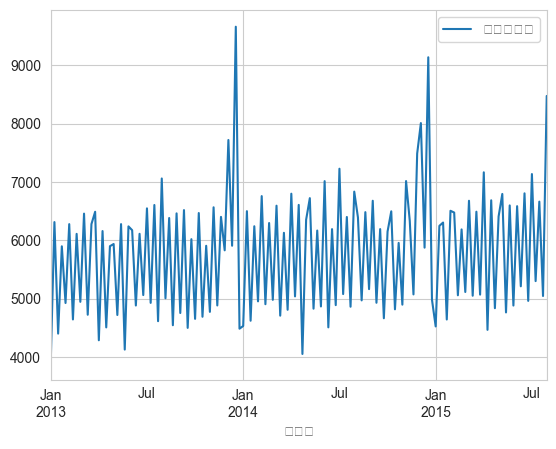

In [158]:
# ARIMA의 p,d,q는 ACF/PACF 그래프에서 찾는데, 일별 데이터는 그래프가 너무 지저분해서 p,q를 제대로 못찾기에, 주간 데이터로 리샘플링


# 매출 데이터를 주 단위로 요약(리샘플링)하는 단계
# 사용할 모델 종류: ARIMA(자기회귀 누적 이동평균 모델)


# 1) 먼저 '예상매출액' 컬럼만 선택하고
train_arima = train[['예상매출액']]

# 2) 그다음 주간 리샘플링 + 평균
train_arima = train_arima.resample('W').mean()

# 3) 그래프
train_arima.plot()



In [159]:
train_arima.head()

,예상매출액
매출일,
2013-01-06,3906.314098
2013-01-13,6313.289174
2013-01-20,4404.582319
2013-01-27,5898.804484
2013-02-03,4928.382960


### 해석

- Index = 날짜(Date) → DatetimeIndex

- 값 = 1주간 평균 매출(Sales)

- 값이 완만하고 규칙적(=stationary에 가깝게) 보임

- ARIMA는 아래 3가지 조건을 요구함 :
-
    - DatetimeIndex	날짜가 인덱스로 있어야 함
    - 균일한 간격(weekly)	시계열 간격이 규칙적이어야 함
    - 안정적인 값	너무 요동치지 않아야 패턴을 찾음

### 해석

ARIMA 모델의 하이퍼파라미터 튜닝(Hyperparameter Tuning)

앞에서 설명했듯이, SARIMA 모델은 p,d,q 세 가지 파라미터를 가집니다.

따라서 파라미터들의 최족 조합을 선택하기 위해 그리드 서치를 사용할 것입니다.

파라미터 조합 중에서 AIC 값이 가장 낮은 모델이 가장 좋은(적합도가 높은)모델이라고 판단합니다.

In [168]:
# p, d, q 파라미터를 0~1 범위에서 각각 정의 (즉, 0 또는 1)
p = d = q = range(0, 2)

# p, d, q의 모든 가능한 조합 생성 (ARIMA의 비계절성 파라미터 조합)
pdq = list(itertools.product(p, d, q))

# 계절성 파라미터(p, d, q, 계절 주기)를 모두 조합하여 생성
# 여기서는 계절 주기를 12로 설정(SARIMA의 (P, D, Q, s))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# 생성된 파라미터 조합 예시 출력
print('Seasonal ARIMA 파라미터 조합 예시:')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))


Seasonal ARIMA 파라미터 조합 예시:
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


#### (설명)

- ARIMA 모델은 (p, d, q) 세 개의 파라미터가 필요함

- range(0, 2) 는 0, 1 두 개의 값을 의미

- 즉 p는 0 또는 1, d는 0 또는 1, q도 0 또는 1로 설정

- 이 값들을 기반으로 ARIMA 모델의 모든 조합을 만들어볼 예정

- → 왜 0~1?
  - 튜토리얼이 단순 예시를 위해 p,d,q 후보 범위를 좁게 잡은 것.
  - 보통 실전에서는 0~3 범위를 더 많이 씀.

- itertools.product(p, d, q)는 p, d, q 값의 모든 경우의 수를 자동으로 조합해주는 함수

- 예: p=0, d=0, q=0

- 예: p=0, d=0, q=1

- 예: p=1, d=0, q=1

- 이런 조합이 리스트 형태로 pdq에 저장됩니다.

- 이 pdq는 ARIMA 모델에서 비계절성(non-seasonal) 부분에 사용됨

→ 즉, pdq는 ARIMA(p, d, q) 후보 모델 리스트.

SARIMA는 계절성까지 반영하는 모델이므로 다음 4개의 파라미터가 필요함:
(P, D, Q, s)

여기서 P = 계절 AR, D = 계절 차분, Q = 계절 MA

itertools.product(p, d, q)는 P, D, Q의 모든 조합을 생성

그 뒤 계절 주기(s) = 12를 붙여서 튜플로 만듦

예: (0, 1, 0, 12)

이걸 모든 조합에 대해 반복

→ 즉, seasonal_pdq는 SARIMA(P, D, Q, 12) 후보 모델 리스트.

- pdq 리스트 안의 두 번째 요소 = 어떤 (p, d, q) 조합

- seasonal_pdq 리스트 안의 요소 = 어떤 (P, D, Q, s) 조합

- 두 개를 곱한 형태가 SARIMAX 모델 구조임

- 예 출력:

- SARIMAX: (0, 1, 1) x (0, 1, 1, 12)


- 의미:

- 비계절성: ARIMA(0,1,1)

- 계절성: (0,1,1,12)

- 즉 SARIMA(0,1,1)(0,1,1,12)

위에서, 파라미터 후보 리스트(모든 조합)를 만들었습니다.
#### 이 조합들을 하나씩 모두 실행해 보면서, 어떤 조합이 가장 낮은 AIC 점수를 주는지 확인해 보겠습니다.

In [169]:
# Determing p,d,q combinations with AIC scores.      # p,d,q(비계절) + 계절 파라미터 조합마다 AIC 점수를 계산해 보는 단계 (그리드 서치)
for param in pdq:                                   # 비계절 ARIMA 파라미터 조합 리스트 pdq에서 (p,d,q) 하나씩 꺼내서 반복
    for param_seasonal in seasonal_pdq:             # 계절 ARIMA 파라미터 조합 리스트 seasonal_pdq에서 (P,D,Q,s) 하나씩 꺼내서 반복
        try:                                        # 일부 조합은 수렴 실패/에러가 날 수 있으므로 예외 처리로 감싸서 계속 진행
            mod = sm.tsa.statespace.SARIMAX(        # SARIMAX(Seasonal ARIMA with eXogenous) 모델 객체 생성
                train_arima,                        # 주간 리샘플링된 시계열 데이터(train_arima)를 입력으로 사용
                order=param,                        # 비계절 파라미터 (p,d,q)를 이 조합(param)으로 설정
                seasonal_order=param_seasonal,      # 계절 파라미터 (P,D,Q,s)를 이 조합(param_seasonal)으로 설정
                enforce_stationarity=False,         # 강제로 정상성(stationarity)을 요구하지 않도록 설정 (더 많은 조합 허용)
                enforce_invertibility=False         # 역가역성(invertibility) 조건도 강제하지 않도록 설정 (모델 수렴 폭을 넓힘)
            )

            results = mod.fit()                     # 위에서 정의한 SARIMAX 모델을 실제로 학습(fit)하여 결과 객체(results) 생성

            print(                                  # 현재 파라미터 조합과 그에 대한 AIC 값을 출력
                'ARIMA{}x{}12 - AIC:{}'.format(     # 예: ARIMA(1,1,1)x(1,1,1,12) - AIC:1234.56 형태로 문자열 생성
                    param,                          # 비계절 파라미터 (p,d,q) 출력용
                    param_seasonal,                 # 계절 파라미터 (P,D,Q,s) 출력용
                    results.aic                     # 이 모델이 갖는 AIC 점수 (Akaike Information Criterion)
                )
            )
        except:                                     # 어떤 조합에서 에러가 발생하더라도
            continue                                # 그냥 건너뛰고 다음 파라미터 조합으로 계속 진행


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2708.8196371542945
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2357.2039807689553
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2142.9121481207667
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1893.8220522795887
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2163.085669279766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2116.705791267356
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1919.9439695857754
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1894.9524107260452
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2592.336694340632
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2305.8868305015617
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2103.0171891135683
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1856.635325967073
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2146.0426171360705
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2066.908667141189
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1902.4415089752115
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1852.8841842545642
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2368.481953362583
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2154.580453193137

#### 해석

따라서, 위의 그리드 서치 결과를 통해
최적의 파라미터는 (ARIMA(1, 1, 1) × (1, 1, 1, 12))이며,
해당 모델의 AIC 값은 1807.3489408440882임을 확인할 수 있다.

1) 문장 해석

    “즉, 위의 그리드 서치 결과, 가장 낮은 AIC 값을 주는 최적 모델은 ARIMA(1,1,1) × (1,1,1,12) 입니다.”

2) 상황 정리

    그리드 서치를 통해 여러 ARIMA/SARIMA 모델을 학습시킨 뒤, 각 모델의 AIC 값을 비교하였습니다.

    그 결과, AIC가 가장 낮은 모델이 “현재 데이터 패턴을 가장 잘 설명하는 모델”이며, 이는 ARIMA(1,1,1)(1,1,1,12)으로 확인되었습니다.

    따라서 이 모델이 최종적으로 선택된 모델입니다.

3) 파라미터 의미 정리

    (1) 비계절(Non-seasonal) ARIMA 부분: ARIMA(1,1,1)

    파라미터	의미

    p = 1	직전 값(1 lag)의 영향을 반영하는 자기회귀(AR) 요소입니다.

    d = 1	1차 차분을 적용하여 추세를 제거하고 정상성을 확보합니다.

    q = 1	직전 예측 오차의 영향을 반영하는 이동평균(MA) 요소입니다.

즉, “직전 값 + 직전 오차 + 1차 차분”을 사용해 현재 값을 예측하는 구조입니다.

(2) 계절(Seasonal) ARIMA 부분: (1,1,1,12)

    파라미터	의미

    P = 1	12단계 전(계절 lag)의 값이 현재 값에 영향을 줍니다.

    D = 1	계절성을 안정화하기 위해 계절 차분을 1회 적용합니다.

    Q = 1	12단계 전 예측 오차가 현재 예측에 반영됩니다.

    s = 12	계절 주기(12단위 반복 패턴)입니다.

    따라서 이 모델은 “12단위 반복 패턴이 존재한다”는 가정 하에 계절성을 반영한 구조로 동작합니다.

4) 머신러닝 관점에서 이해하면 이 과정은 머신러닝의 하이퍼파라미터 튜닝과 동일합니다.

    여러 (p,d,q), (P,D,Q,s) 조합을 생성하고 각 조합으로 모델을 학습시킨 뒤, AIC 값을 비교하여 가장 낮은 조합을 최적 모델로 선택하는 방식입니다.

    즉, ARIMA(1,1,1)(1,1,1,12)는 현재 데이터셋에서 가장 좋은 성능을 보인 “최적 하이퍼파라미터 세트”입니다.

5) AIC는 왜 평가지표가 아니라 ‘기준값’인가?

    AIC는 모델의 성능을 평가하는 것처럼 보이지만, 정확히 말하면 “비교를 위한 기준값”입니다.

    (1) AIC의 목적

    AIC는 다음 두 요소를 동시에 고려하는 지표입니다.

    모델이 데이터를 얼마나 잘 설명하는가(적합도)

    모델이 얼마나 단순한가(복잡도 패널티)

        공식:
        AIC = -2 * log-likelihood + 2 * k

        (log-likelihood = 적합도, k = 파라미터 개수)

    따라서 “적합도 + 복잡도”를 함께 평가합니다.

    (2) 절대값 자체에는 의미가 없습니다

    validation loss(MSE/MAE)는 값이 작을수록 “예측 오차가 작다”는 의미가 있지만,

    AIC는 수치 자체는 의미가 없으며, “여러 모델 중에서 가장 낮은 것이 가장 좋다”라는 상대적 모델 선택 기준으로만 사용됩니다.

    (3) 차이 정리
    항목	        AIC	                    Validation loss (MSE/MAE 등)
    절대값 의미	없습니다	                있습니다
    목적	최적 모델 선택	                예측 오차 평가
    구성	        적합도 + 복잡도 패널티	    오차 기반 손실값
    사용 방식	여러 모델 중 비교용	    학습 과정에서 최적화 대상

    즉, AIC는 “평가 지표”라기보다는
    여러 모델 중 최적 모델을 선택하기 위한 “기준값”입니다.

### 최적화 모델(Fitting the model)

그리드서치로 찾은 최적 파라미터로 SARIMA 모델을 실제로 학습시키는 단계로, 모델이 패턴을 이해합니다.

이는 향 후 예측값을 생성하는데 사용됩니다.

이제 SARIMA 모델(계절 ARIMA)에 데이터를 학습시키겠습니다.

In [170]:
# SARIMA 모델에 데이터를 학습시키는 단계입니다.
model_sarima = sm.tsa.statespace.SARIMAX(
    train_arima,                   # 주간 단위로 리샘플링된 학습용 시계열 데이터입니다.
    order=(1, 1, 1),               # 비계절 ARIMA 파라미터 (p=1, d=1, q=1)을 설정합니다.
    seasonal_order=(1, 1, 1, 12),  # 계절성 SARIMA 파라미터 (P=1, D=1, Q=1, s=12)을 설정합니다.
    enforce_stationarity=False,    # 정상성(stationarity) 조건을 강제로 적용하지 않습니다.
    enforce_invertibility=False    # 가역성(invertibility) 조건을 강제로 적용하지 않습니다.
)

# 위에서 정의한 SARIMA 모델을 데이터에 맞추어 실제로 학습(fit)합니다.
results_sarima = model_sarima.fit()

# 학습된 SARIMA 모델의 파라미터 요약 정보 중,
# 두 번째 테이블(계수 관련 테이블)만 출력합니다.
print(results_sarima.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5543      0.098     -5.652      0.000      -0.747      -0.362
ma.L1         -1.1418      0.055    -20.766      0.000      -1.250      -1.034
ar.S.L12      -0.1554      0.110     -1.417      0.156      -0.370       0.060
ma.S.L12      -1.0093      0.700     -1.441      0.150      -2.382       0.364
sigma2      6.236e+05   4.65e+05      1.342      0.180   -2.87e+05    1.53e+06


### 해석

“계수(coef)는 각 시점의 값이나 오차가 현재 예측에 얼마나 영향을 주는지를 나타내고,
p-value는 그 영향이 통계적으로 의미 있는지를 보여줍니다.

제가 분석한 결과에서는 **ar(1)**과 ma(1) 계수의 p-value가 0.05 이하로 유의했습니다.
즉, 직전 매출 값과 직전 예측 오차가 현재 매출을 결정하는 핵심 변수라는 뜻입니다.

특히 ar(1)이 음수여서 평균회귀 성향, 즉 매출이 갑자기 높아지면 다시 정상 수준으로 돌아오는 구조가 확인되었습니다.
그리고 ma(1)이 크게 음수이기 때문에 수요 변동성과 예측오차의 영향력이 크고,
단기 이벤트·프로모션·날씨 변화 등 외생 요인이 매출에 큰 영향을 준다는 인사이트를 도출했습니다.

반면 12주 단위 계절성 계수들은 p-value가 유의하지 않아,
계절 패턴보다는 단기 요인이 매출 변동을 더 크게 만든다고 해석했습니다.

실제로는 이 결과를 기반으로
‘프로모션 효과는 단기적이며 반복적이지 않다’,
‘재고 계획은 단기 변동성을 고려해야 한다’,
‘계절성 기반의 예측보다는 단기 이벤트 기반 예측 모델이 더 적합하다’
라는 실무적 판단이 가능합니다.”

#### 1) coef(계수) — 영향력의 크기와 방향을 의미함

    (1) coef란?

    coef는 “이 변수(AR, MA 등)가 예측값에 얼마나 영향을 주는지”를 나타냅니다.

    양수(+) → 현재 값이 증가하는 방향으로 영향

    음수(-) → 현재 값이 감소하는 방향으로 영향

    절댓값이 크다 → 영향력이 크다

    절댓값이 작다 → 영향력이 약하다

    즉,

    coef는 "이 요소가 예측값을 얼마나, 어떤 방향으로 움직이게 만드는가"를 나타내는 값입니다.

    (2) 예시로 해석: ar.L1 = -0.5543

    의미:

    직전 매출 값이 올라가면 현재 매출은 내려가는 경향

    “직전 값이 현재값을 끌어내리는 힘”이 -0.55 정도로 존재

    평균 회귀(Mean reversion) 구조가 강함

    즉,

    매출이 전날 갑자기 높았다면 다음날은 다시 떨어지는 경향이 있다.

    (3) 예시로 해석: ma.L1 = -1.1418

    의미:

    직전 예측오차(error)가 현재 예측에 매우 큰 영향

    -1.14 → 영향력이 매우 큼

    오차에 대한 민감도가 높아 수요 변동성이 크다는 신호

    즉,

    매출이 갑자기 튀거나 떨어지면 그 오차가 다음날 예측에도 강하게 반영된다.

    2) p-value — “이 계수가 의미 있는가?”를 검증하는 지표

    p-value란?

    “이 계수가 0이 아닐 확률이 얼마나 높은가?”

    즉, “이 계수가 진짜 유의미한 역할을 하고 있는가?”

    라는 질문에 답하는 값입니다.

    p-value < 0.05 → 유의하다 (실제로 영향을 준다)

    p-value ≥ 0.05 → 유의하지 않음 (그 영향이 우연일 가능성이 큼)

    왜 필요한가?

    coef 값이 있다고 해서, 그것이 진짜 의미 있는 영향이라고 볼 수 없습니다.

    데이터 우연성 때문에 나타났을 수도 있기 때문입니다.

    p-value는

    “이 계수가 통계적으로 의미가 있는지 없는지”

    를 판별합니다.

    예시로 해석

        (1) ar.L1

            coef = -0.5543

            p-value = 0.000

            해석:

            직전 매출이 현재 매출에 영향을 준다는 것이 통계적으로 매우 확실

            → 이 계수는 “진짜 영향력을 가진 요소”

        즉,

        “직전 매출이 다음 매출을 끌어내리는 구조가 실제로 존재한다.”

        (2) ar.S.L12

            coef = -0.1554

            p-value = 0.156

            해석:

            계수가 존재하긴 하지만

            영향이 우연일 가능성이 크다 → 통계적으로 유의하지 않다

        즉,

        “12단위 계절성 패턴은 뚜렷하다고 보긴 어렵다.”


3) 왜 coef와 p-value가 함께 필요할까?


    ① coef만 보면 "영향 크기"는 알 수 있지만

        → 이 영향이 진짜인지, 우연인지 알 수 없음

    ② p-value만 보면 "영향이 유의한지"는 알 수 있지만

        → 영향의 **방향(+, -)**과 크기는 알 수 없음

        따라서 둘을 함께 봐야 한다:

    항목	의미

    coef	영향을 얼마나, 어떤 방향으로 주는가?

    p-value	그 영향이 진짜인가, 우연인가?


4) 핵심 요약

    coef

    모델이 학습한 “영향력의 크기와 방향”

    +면 증가, -면 감소 영향

    절댓값이 클수록 영향 큼

    p-value

    이 계수가 실제로 의미 있는지 검증

    < 0.05 이면 “실제로 영향력이 있다”

    ≥ 0.05 이면 “영향력이 있다고 보기 어렵다”


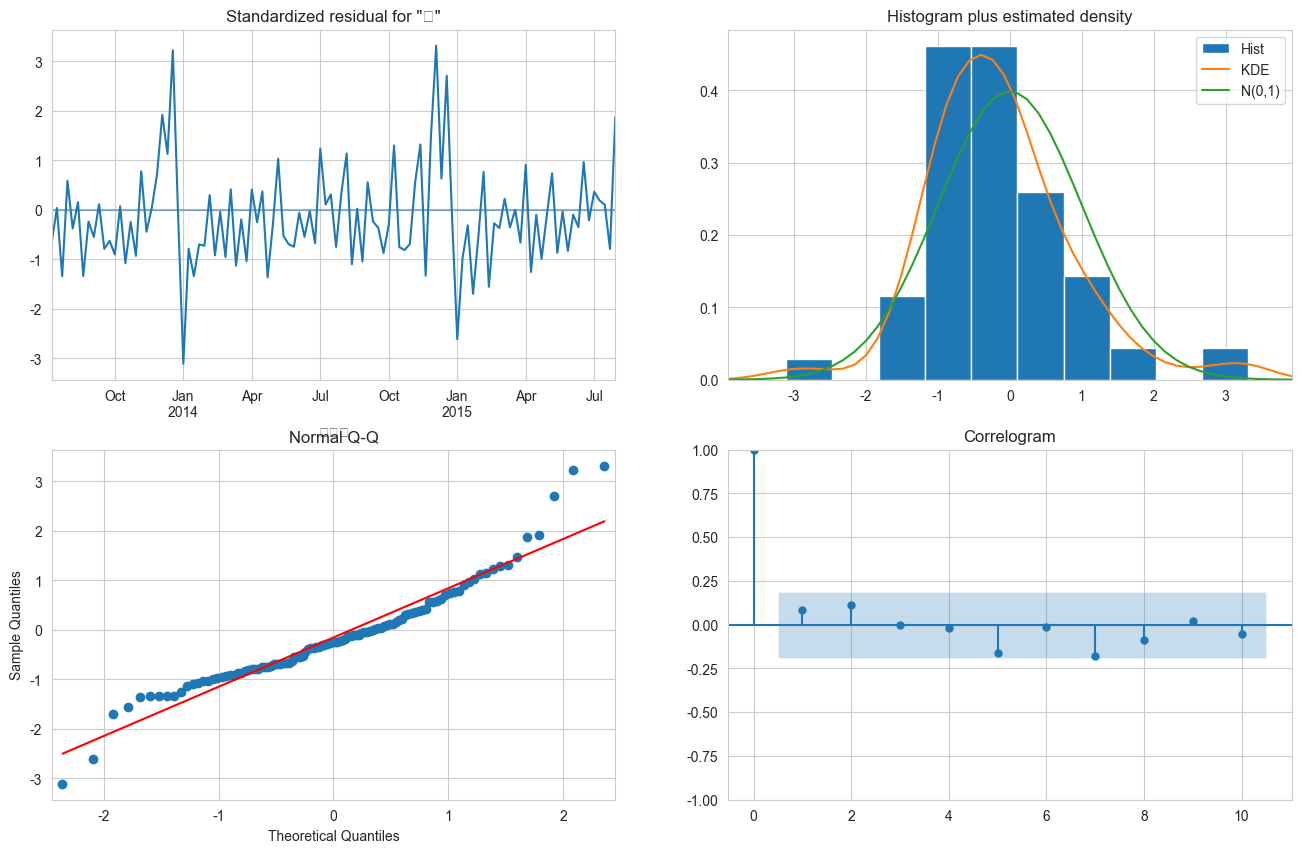

In [171]:
# SARIMA 모델의 진단 플롯(diagnostic plots)을 확인하여
# 잔차가 정상성(stationarity)·독립성(independence)·정규성(normality)을 만족하는지 검증합니다.
results_sarima.plot_diagnostics(figsize=(16, 10))

# 진단 플롯을 화면에 출력합니다.
plt.show()


1) 이 코드는 무엇을 하는가?

    SARIMA 모델이 “정상적으로 잘 작동하는 모델인지” 검사하는 단계입니다.
    모델의 잔차(residuals)가 통계적으로 문제 없는지 확인하는 절차입니다.

    총 4개의 플롯이 출력됩니다:

    Residuals plot
    → 잔차가 시간에 따라 일정하게 분포하는지 (패턴이 없어야 함)

    Kernel density plot
    → 잔차가 정규분포에 가까운지

    Normal Q–Q plot
    → 잔차의 정규성 확인

    Correlogram (ACF)
    → 잔차가 자기상관이 없는지 확인

2) 왜 해야 하는가?

    ARIMA/SARIMA 모델이 ‘좋은 모델’이 되기 위해서는, 잔차가 백색잡음(white noise)이어야 합니다.

    즉, 예측하지 못한 패턴이 남아 있으면 안 됩니다. (백색잡음:보시다시피 평균과 분산이 일정함을 알 수 있고, 어떠한 추세도 관측되지 않습니다.)

    plot_diagnostics()는 바로 이것을 확인하는 기능입니다.

3) 면접에서 이렇게 설명하면 가장 좋다

    “SARIMA 모델의 신뢰성을 검증하기 위해 꼭 필요한 절차가 잔차 진단입니다.
    plot_diagnostics()는 잔차가 정상성, 독립성, 정규성을 만족하는지 한 번에 보여줍니다.

    잔차에 패턴이 보이면 ‘모델이 설명하지 못한 구조가 남아 있다’는 뜻으로,
    계절성 추가·파라미터 변경·외부 변수 도입 등을 고려해야 합니다.

    반대로, 잔차가 백색잡음처럼 보이면
    모델이 데이터 구조를 충분히 설명하고 있으며 예측에 사용할 수 있다는 의미입니다.”

4) 실제 비즈니스에서는 어떻게 해석하는가?

    잔차가 패턴 없이 균등하게 분포하면
    → 매출 변동을 모델이 충분히 설명했다는 뜻이다.

    잔차에 특정 요일/월/프로모션 패턴이 남아 있으면
    → SARIMA가 설명하지 못한 비즈니스 요인이 존재한다는 뜻이다.
    → 날씨, 할인, 방문자 수 등 외생 변수를 추가해야 한다.

### 시각화 해석

1) Standardized Residuals 플롯

    “잔차가 시간축에서 랜덤하게 흩어져 있으면 모델이 패턴을 잘 설명한다.”

    왜 이런 해석이 가능한가? (쉽게 설명)

    시계열 모델의 핵심 목표는
    데이터 안에 있는 규칙·패턴(추세, 계절성, 반복성 등)을 모두 흡수해서 제거하는 것입니다.

    모델이 해야 할 일:

    - 지난 값과의 관계 설명

    - 예측 오차의 패턴 설명

    - 계절/반복 패턴 설명

    - 추세(계속 증가/감소하는 흐름) 제거

      즉, 예측 가능한 구조는 모두 모델이 설명해야 합니다.

    그래서 잔차(residual)는

    “모델이 설명하지 못한 나머지”인데, 모델이 완벽할수록 잔차는 아무 규칙 없는 랜덤 노이즈처럼 보이는 것이 정상입니다.

    잔차 플롯에서… 특정 구간 전체가 위쪽에 몰리면 → 추세를 제대로 제거 못한 것

    일정한 간격으로 커졌다 작아졌다 반복되면 → 계절성 미반영

    어떤 구간은 변동이 크고, 어떤 구간은 작으면 → ‘이분산’이라 해서 오차 안정성이 깨진 것

    이런 게 보이면 모델이 아직 데이터의 패턴을 다 설명하지 못했다는 뜻입니다.

    지금처럼 잔차가 0 근처에서 랜덤하게 흩어져 있다면,

    “모델이 설명해야 할 패턴은 거의 제거되었다”고 판단할 수 있습니다.

2) 히스토그램 + KDE 플롯

    “잔차가 종 모양(정규분포)에 가깝다면 모델 가정을 잘 만족한다.”

    왜 이런 해석이 가능한가?

    ARIMA/SARIMA는 “잔차가 정규분포처럼 생겼다”는 조건을 기본 전제로 삼고 추정하는 모델입니다.

    즉, 모델은 ‘오차가 평균 0, 좌우대칭, 과도한 극단값이 없는 형태’라고 가정하고 계산을 진행합니다.

    이 가정이 맞아야:

    모델 계수 추정이 안정적이고

    모델 비교 지표(AIC, BIC)가 제대로 작동하고, p-value, 신뢰구간 같은 통계 검정이 의미를 가집니다.

    히스토그램과 KDE는 잔차가 실제로 그런 형태인지 확인하는 도구입니다.

    가운데가 두툼하고

    좌우가 자연스럽게 줄어들고

    KDE 곡선이 부드럽고 좌우대칭이면

    → “정규분포 가정을 잘 만족한다”는 의미입니다.

    여기서 KDE 곡선은
    “히스토그램을 부드럽게 그린 실제 분포 모양”이라고 생각하면 됩니다.

    지금 그래프는 정규분포와 거의 유사하므로 모델을 통계적으로 해석하는 데 문제가 없다는 뜻입니다.

3) Normal Q–Q Plot

    “점들이 대각선 근처에 있으면 잔차가 정규분포를 따른다.”

    왜 이런 해석이 가능한가?

    Q–Q plot은 “잔차가 이론적으로 기대되는 정규분포와 어느 정도 비슷한지”를 직선과 점의 비교로 판단하는 그래프입니다.

    점들이 직선 위에 거의 일치 → 분포 모양이 매우 유사

    S자 모양 → 꼬리가 두꺼움

    전체적으로 휘어짐 → 비대칭성

    끝부분이 크게 튀면 → 극단값 문제

    이런 패턴이 보이면 정규성을 위반한 것입니다.

    하지만 현재 결과는

    대부분 직선을 잘 따라가고

    양끝만 조금 벗어난 정도

    즉, 현실 데이터에서 자주 보이는 정상적인 형태이며, 정규성 가정을 위배하지 않는 수준입니다.

4) ACF(잔차의 자기상관) 플롯

    “막대가 모두 신뢰구간 안에 있으면 잔차가 백색잡음(white noise)이다.”

    왜 이런 해석이 가능한가?

    모델이 완성되면 잔차들끼리는 아무 상관관계가 없어야 정상입니다.

    만약 잔차에 상관이 남아 있으면,

    특정 시점의 오차가 다음 시점 오차에 영향을 준다는 뜻 → 모델 미스펙

    즉, AR 또는 MA 항을 더 추가해야 함

    또는 남은 계절성이 있다는 신호

    그런데 현재 ACF 플롯에서는

    대부분의 막대가 신뢰구간 안에 있고

    lag 1 이후 거의 0 근처

    즉, 잔차끼리 의미 있는 상관이 없다 → 모델이 패턴을 잘 제거했다는 뜻입니다.

    잔차가 이렇게 되어야

    비로소 “백색잡음(즉, 순수 랜덤 오차)”라고 부를 수 있습니다.

### 모델 예측(prediction)

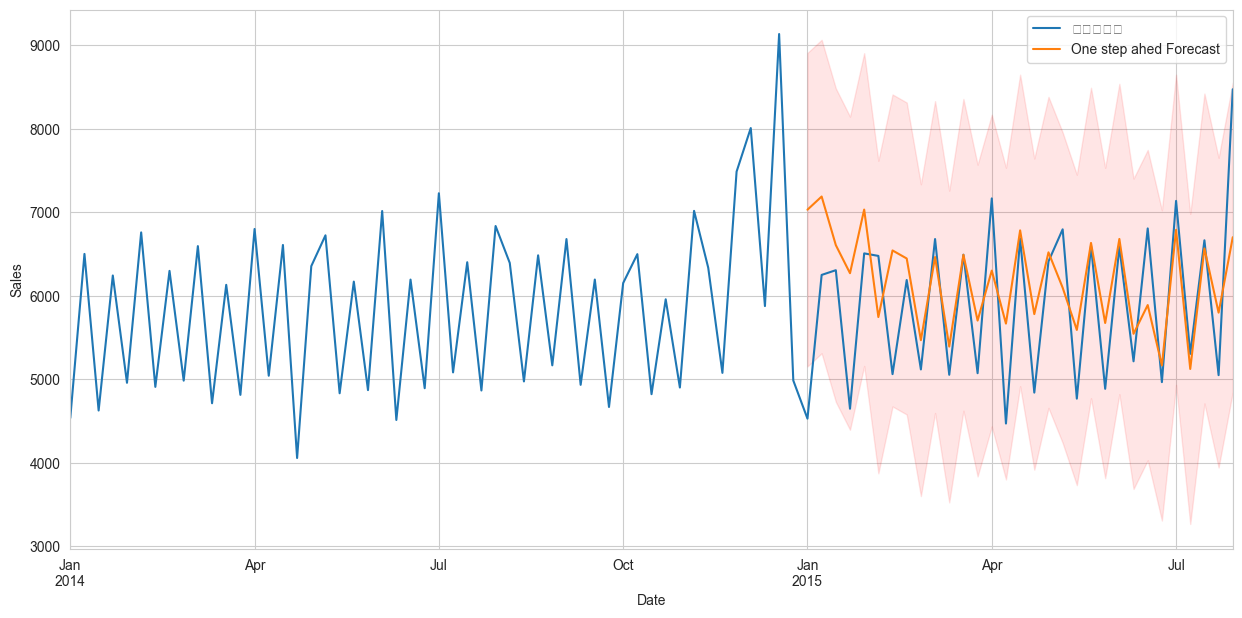

Root Mean Squared Error =  867.955049343132


In [172]:
# 모델 예측(Model prediction)을 수행합니다.
pred = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)  # 2015-01-04 날짜부터 한 스텝씩 앞을 예측하는 결과 객체를 생성합니다.

# 예측값의 신뢰구간(confidence interval)을 구합니다.
pred_ci = pred.conf_int()  # 각 시점별 예측구간(하한, 상한)을 데이터프레임 형태로 가져옵니다.

# 2014년 이후의 실제 관측값 시계열을 그립니다.
ax = train_arima['2014':].plot(label='Observed', figsize=(15,7))  # 2014년 이후 구간만 잘라서 실제 매출 시계열을 플롯합니다.

# 같은 축(ax)에 SARIMA의 예측 평균값을 함께 그립니다.
pred.predicted_mean.plot(ax=ax, label='One step ahed Forecast', alpha=1)  # 한 스텝 앞 예측값(모델 예측 평균)을 관측값 위에 겹쳐서 플롯합니다.

# 예측 구간(신뢰구간)을 음영으로 표시합니다.
ax.fill_between(
    pred_ci.index,           # 신뢰구간의 x축(날짜 인덱스)을 지정합니다.
    pred_ci.iloc[:, 0],      # 신뢰구간 하한(lower bound)을 y축 아래 경계로 사용합니다.
    pred_ci.iloc[:, 1],      # 신뢰구간 상한(upper bound)을 y축 위 경계로 사용합니다.
    color='r', alpha=.1      # 붉은색 계열로 투명도 0.1을 적용하여 음영 영역을 칠합니다.
)

# x축 라벨을 설정합니다.
ax.set_xlabel('Date')  # x축에 날짜(Date)라는 라벨을 붙입니다.

# y축 라벨을 설정합니다.
ax.set_ylabel('Sales')  # y축에 매출(Sales)이라는 라벨을 붙입니다.

# 범례(Observed, Forecast)를 표시합니다.
plt.legend()  # 플롯에 설정된 label 정보를 바탕으로 범례를 출력합니다.

# 그래프를 화면에 보여줍니다.
plt.show()  # 지금까지 설정한 시각화를 실제로 렌더링합니다.

# 모델이 예측한 시계열(예측 평균값)을 별도 변수로 저장합니다.
train_arima_forecasted = pred.predicted_mean  # 예측된 매출 시계열을 train_arima_forecasted 변수에 담습니다.

# 실제 관측값 중 예측 구간(2015-01-04 이후)만 잘라서 진짜 값으로 사용합니다.
train_arima_truth = train_arima['2015-01-04':]  # 2015-01-04 이후 실제 매출 값을 비교용 정답 데이터로 사용합니다.

# 예측값과 실제값 간의 RMSE를 계산합니다.
rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))  # 실제값과 예측값의 평균제곱오차를 구한 뒤 제곱근을 취해 RMSE를 계산합니다.

# RMSE 값을 출력합니다.
print('Root Mean Squared Error = ', rms_arima)  # ARIMA(SARIMA) 모델의 예측 오차 크기를 RMSE로 출력합니다.


### 해석

1) 파란색 선 = 실제 매출(Sales)

    2014년부터 이어지는 실제 매출 시계열로, 일·주 단위의 반복 패턴이 뚜렷하게 나타납니다.
    변동 폭은 일정하지만, 간헐적으로 큰 스파이크(매출 급등)가 존재합니다.
    따라서 이 데이터는 계절성과 단기 변동성이 강한 시계열임을 다시 확인할 수 있습니다.
    (ACF 그래프에서도 7일 단위(혹은 그 배수)에서 강한 자기상관이 나타났기 때문에, 이 데이터는 실제로 계절 주기가 존재하는 시계열이 맞습니다.)
    (단, 시계열이 추세가 강하면 지속적으로 상승하거나, 감소하는 형태인데, 전반적인 평균 수준은 유지할 수 있고, 장기적으로 늘고 주는 뚜렷한 방향성이 없기에
    추세가 강하지 않은 시계열입니다.)

2) 주황색 선 = SARIMA의 예측 값 (One-step ahead Forecast)

    2015년 1월 4일 이후부터 모델이 한 스텝씩 예측한 값입니다.
    이 방식은 실제 직전 값을 계속 반영하기 때문에, 예측값이 실제 매출의 중심 흐름을 비교적 안정적으로 따라갑니다.

    즉, 모델은 평균적인 수준과 패턴을 크게 벗어나지 않도록 예측하고 있습니다.

3) 빨간 음영 = 예측 신뢰구간 (95% Confidence Interval)

    이 영역은 특정 날짜의 매출이 이 범위 안에 있을 가능성이 높다는 의미입니다.

    신뢰구간이 시간이 갈수록 넓어지는 이유는 다음과 같습니다.

    미래로 갈수록 예측 불확실성이 증가하고

    랜덤 변동이 누적되며

    SARIMA 모델 구조상 예측 분산이 시간에 따라 확장되기 때문입니다.

    따라서 신뢰구간 확대는 정상적인 모델 동작입니다.

4) 모델 예측 품질에 대한 해석

    (1) 긍정적인 부분

    예측값이 실제값의 평균적 흐름을 잘 따라간다.

    실제 매출의 대부분이 신뢰구간 내부에 위치한다.
    이는 모델의 변동성 추정(불확실성 추정)이 타당하다는 것을 의미한다.

    (2) 한계

    신뢰구간이 비교적 넓다.
    이는 변동성이 강한 시계열 특성상, 모델이 정확하게 한 점 예측을 하기 어렵다는 의미다.

    큰 스파이크나 급락과 같은 비정상적 변동은 SARIMA가 포착하지 못한다.
    전통적 시계열 모델의 일반적인 한계에 해당한다.

5) 전체 요약

    SARIMA 모델은 전체적인 수준과 반복 패턴은 잘 예측하지만,
    데이터 자체의 변동성이 커서 미래 예측의 불확실성 역시 크게 나타난다.
    따라서 평균적 추세를 파악하는 데는 유용하지만, 개별 시점의 정확한 매출을 예측하는 데는 제약이 있다.

### 설명

1. 2015-01-04 이후 구간을 예측 평가 구간으로 잡고

2. 그 구간에 대해 SARIMA가 한 스텝씩 예측한 값과 불확실성(신뢰구간)을 계산한 뒤

3. 실제 매출과 겹쳐 그려서 시각적으로 비교하고

4. RMSE로 평균 오차 크기를 수치화해서 모델 성능을 검증하는 코드입니다.


1) 예측 구간 설정 + 예측 수행

    pred = results_sarima.get_prediction(start=pd.to_datetime('2015-1-4'), dynamic=False)

    왜 이렇게 썼는가?

    start='2015-01-04'

    → “2015-01-04 이후부터는 테스트 구간처럼 보고, 예측이 얼마나 잘 맞는지 보자”라는 기준 시점을 정한 것 입니다.

    → 앞 구간(2013~2014)은 주로 모델 학습·구조 파악용,

     2015년 이후는 성능 평가용으로 나눈 셈입니다.


    get_prediction을 쓰는 이유

    → “각 시점별 예측값 + 신뢰구간까지 한 번에 받고 싶어서”입니다.

    → 단순 predict()보다 평가·시각화에 적합합니다.

    dynamic=False

    → “one-step ahead forecast만 하겠다”는 의미입니다.

    → 한 줄로 말하면:

    dynamic=False :

    매 시점마다 실제 관측값을 사용하는 방식 (가장 보수적인 평가)

    → “실제 매출이 주어졌을 때 다음 매출을 얼마나 잘 맞추냐?”

    (참고) dynamic=True: 과거 예측값을 계속 이어서 사용하는 완전 미래 예측 방식

    즉,

    “2015년 1월 4일부터는,
    ‘실제 값’을 활용하는 one-step ahead 방식으로, 모델이 얼마나 잘 따라가는지 보자” 라고 설정한 것입니다.

2) 신뢰구간(불확실성)까지 포함해서 예측값 준비

    pred_ci = pred.conf_int()

    왜 필요한가?

    예측값 하나만 보면
    → “대략 이 정도겠지” 수준입니다.

    하지만 실무/분석에서는
    → “얼마나 불확실한 예측인지”도 중요합니다.

    conf_int()는

    “이 날짜의 매출은 대략 이 값 ± 얼마 범위 안에 있을 가능성이 크다”
    → 그 범위를 상·하한으로 제공합니다.

    나중에 fill_between으로 그림에 음영 표시해서

    “이 구간 안에 실제 매출이 들어오면, 모델이 확률적으로도 괜찮게 맞췄다” 를 시각적으로 확인하기 위함입니다.

3) 실제값 + 예측값을 하나의 그래프에 겹쳐 그리기

    ax = train_arima['2014':].plot(label='Observed', figsize=(15,7))

    pred.predicted_mean.plot(ax=ax, label='One step ahed Forecast', alpha=1)


    왜 2014년 이후만 그릴까?

    전체 기간(몇 년)을 다 그리면

    → 그래프가 너무 길어지고,

    → 예측 기간(2015년 이후) 부분이 잘 안 보입니다.

    그래서 2014년 이후 구간으로 “줌인”해서

    2014년 말 실제 패턴

    2015년 예측이 그 패턴을 잘 이어받는지

    를 집중해서 보기 위해 이 구간만 그립니다.

    왜 같은 축에 predicted_mean을 올릴까?

    목적: “실제 vs 예측”을 직관적으로 비교하기 위함입니다.

    실제값(Observed) 그래프와

    SARIMA 예측값(One-step ahead Forecast)을

    같은 축에 겹쳐야,

    어디서 잘 맞고

    어디서 많이 벗어나는지

    눈으로 바로 확인할 수 있습니다.

4) 신뢰구간을 그래프에 음영으로 표시

   ax.fill_between(
        pred_ci.index,
        pred_ci.iloc[:, 0],
        pred_ci.iloc[:, 1],
        color='r', alpha=.1
    )

    왜 이렇게까지 그릴까?

    이 영역은

   → “이 날짜의 매출은 이 빨간 음영 범위 안에 있을 것이다”

    라는 예측 구간(불확실성 범위)입니다.

    실제 관측값이 대부분 이 범위 안에 들어온다면:

    모델의 불확실성 추정(분산)도 괜찮다는 의미

    만약 실제값이 자주 범위 밖으로 튀어나가면:

    모델이 변동성을 과소/과대 추정하고 있는 것

    즉,

    “단순히 평균만 잘 맞췄는지가 아니라,

    ‘위험 범위까지 제대로 잡았는지’를 확인하기 위해서” 라고 보시면 됩니다.

5) 예측값과 실제값을 같은 기간으로 맞춰서 비교

    train_arima_forecasted = pred.predicted_mean

    train_arima_truth = train_arima['2015-01-04':]

    왜 이렇게 나누나?

    train_arima_forecasted
    → 모델이 예측한 값

    train_arima_truth
    → 같은 날짜 구간의 실제 관측값

    이 둘의 기간이 “날짜별로 1:1로 대응”해야
    → RMSE 같은 수치 평가를 할 수 있습니다.

    그래서 기준 날짜인 '2015-01-04' 이후 구간만 잘라서

    예측값 vs 실제값을 공통 구간으로 맞춘 것입니다.

6) RMSE로 성능 평가

   rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))

    print('Root Mean Squared Error = ', rms_arima)


    왜 RMSE를 쓰는가?


    RMSE는
    → “평균적으로 얼마나 매출을 틀리고 있는지”를 단위(스케일 그대로)로 보여줍니다.

    예를 들어,

    RMSE가 500이면

    → “이 모델은 평균적으로 매일/매주 500 정도씩 오차를 낸다” 라고 해석 가능합니다.


    이 줄들의 의도는?

    mean_squared_error로 예측값–실제값 차이를 제곱해서 평균

    sqrt로 다시 제곱근을 씌워 스케일 복원

    → “숫자로 모델이 얼마나 잘 맞는지 평가”

    즉,

    앞의 그래프는 “눈으로 보는 평가”,

    RMSE는 “수치로 보는 평가” 역할입니다.